# **Inner Evaluation: FastKmedoids**

## **Requirements**

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import sys
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from  xgboost import XGBRegressor
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')
from sklearn.metrics import mean_absolute_error

In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyMachineLearning_Package_Private')
from PyMachineLearning.preprocessing import encoder, imputer, scaler, features_selector
from PyMachineLearning.evaluation import SimpleEvaluation


In [3]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.data import sort_predictors_for_GG

In [4]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\SupervisedClustering_Package_Private')
from SupervisedClustering.models import FastKmedoidsEstimator

In [5]:
sys.path.insert(0, r"C:\Users\fscielzo\Documents\Packages\BigEDA_Package_Private")
from BigEDA.descriptive import outliers_table

## **Data**

In [6]:
madrid_houses_df = pl.read_csv('Data/madrid_houses_NaNS.csv')
variables_to_remove = ['', 'id', 'district', 'neighborhood', 'sq_mt_allotment']
variables_to_keep = [x for x in madrid_houses_df.columns if x not in variables_to_remove]
madrid_houses_df = madrid_houses_df[variables_to_keep]
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,i64,i64,i64,i64,i64,bool,bool,bool,i64,bool,i64
64.0,2,1,1,3,85000,false,false,true,4,false,1
70.0,3,1,1,4,129900,true,true,true,0,false,1
94.0,2,2,1,1,144247,false,true,true,0,false,1
64.0,2,1,1,-1,109900,false,true,true,0,false,1
108.0,2,2,1,4,260000,false,true,true,0,true,1


In [7]:
quant_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors', 'buy_price']
cat_columns = [x for x in madrid_houses_df.columns if x not in quant_columns]

response = 'buy_price'
quant_predictors = [x for x in quant_columns if x != response]
cat_predictors = [x for x in cat_columns if x != response]
predictors = quant_predictors + cat_predictors

In [8]:
cat_predictors_sorted, p1, p2, p3 = sort_predictors_for_GG(df=madrid_houses_df, quant_predictors=quant_predictors, cat_predictors=cat_predictors)

In [ ]:
cat_predictors_sorted

## **Response and Predictors**

In [9]:
Y = madrid_houses_df[response].to_pandas()
X = madrid_houses_df[predictors].to_pandas()
# The Null values of the Polars columns that are define as Object type by Pandas are treated as None and not as NaN (what we would like)
# The avoid this behavior the next step is necessary
X = X.fillna(value=np.nan)

## **Defining outer evaluation: train-test split**


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.90, random_state=123)
# We set a large train size since we are mainly interested in compare models not in estimating the feature performance (indeed, we could omit the test part and doing the inner eval. with the whole data)

## **Defining inner evaluation: K-Fold Cross Validation**

In [11]:
inner = KFold(n_splits=4, shuffle=True, random_state=111)

In [12]:
inner_score, best_params, inner_results = {}, {}, {}

## **Proportion of outliers**

In [13]:
Y_X_train = pd.concat((Y_train.reset_index(drop=True), X_train.reset_index(drop=True)), axis=1)
Y_X_train_pl = pl.DataFrame(Y_X_train)
mean_prop_outliers = np.round(outliers_table(df=Y_X_train_pl, auto=False, col_names=quant_columns)['prop_outliers'].mean(), 3)
mean_prop_outliers

0.09

## **Example of usage**

In [14]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True, method='iterative_median'))])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True, method='simple_most_frequent'))])

quant_cat_transformer = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                        ('cat', cat_pipeline, cat_predictors_sorted)])

In [15]:
# Defining estimators to be used in each cluster
estimators_RF_XGB_2_clusters = {0: RandomForestRegressor(random_state=123),
                                1: XGBRegressor(random_state=123)}

In [16]:
X_train = quant_cat_transformer.fit_transform(X_train)
X_test = quant_cat_transformer.transform(X_test)
X_train = pd.DataFrame(X_train, columns=quant_predictors + cat_predictors_sorted)
X_test = pd.DataFrame(X_test, columns=quant_predictors + cat_predictors_sorted)

In [17]:
fast_kmedoids_regressor = FastKmedoidsEstimator(estimators=estimators_RF_XGB_2_clusters, 
                                                n_clusters=2, method='pam', init='heuristic', max_iter=100, 
                                                random_state=123,  frac_sample_size=0.015, 
                                                p1=p1, p2=p2, p3=p3, 
                                                d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                                robust_maha_method='trimmed', alpha=0.05, 
                                                y_type='quantitative')

In [18]:
fast_kmedoids_regressor.fit(X=X_train, y=Y_train)
Y_test_hat = fast_kmedoids_regressor.predict(X_test)
mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test)

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.90467672 0.09532328]


172284.2923728645

In [19]:
#np.mean(cross_val_score(X=X_train, y=Y_train, estimator=estimators_RF_XGB_2_clusters[0], cv=inner, scoring='neg_mean_absolute_error'))

## **Pipelines definition**

In [20]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True)),
                           ('scaler', scaler())
                          ])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True))
                        ])

quant_cat_preprocessing = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                          ('cat', cat_pipeline, cat_predictors_sorted)]) 

In [21]:
meta_models = {'XGB': XGBRegressor(random_state=123),
               'RF': RandomForestRegressor(random_state=123)}

clusters_RF = [0,2,4]
clusters_XGB = [1,3]
max_n_clusters = len(clusters_RF + clusters_XGB)

estimators_RF_XGB = {j: meta_models['RF'] for j in clusters_RF}
estimators_RF_XGB.update({j: meta_models['XGB'] for j in clusters_XGB}) 

clustering_estimator = FastKmedoidsEstimator(estimators=estimators_RF_XGB, 
                                                    n_clusters=2, method='pam', init='heuristic', max_iter=100, 
                                                    random_state=123,  frac_sample_size=0.015, 
                                                    p1=p1, p2=p2, p3=p3, 
                                                    d1='robust_mahalanobis', d2='jaccard', d3='matching', q=1,
                                                    robust_maha_method='trimmed', alpha=mean_prop_outliers, 
                                                    y_type='quantitative')

pipeline_clustering_model = Pipeline([('preprocessing', quant_cat_preprocessing),
                                      ('features_selector', features_selector()),
                                      ('clustering_model', clustering_estimator)
                                     ]) 

## **Grids for HPO**

In [22]:
def preprocessing_param_grid(trial):

    # Fix Grid
    param_grid = {
        'preprocessing__quant__imputer__method': trial.suggest_categorical('preprocessing__quant__imputer__method', ['simple_mean', 'simple_median', 'iterative_mean', 'iterative_median']),
        'preprocessing__cat__imputer__method': trial.suggest_categorical('preprocessing__cat__imputer__method', ['simple_most_frequent']),
        'preprocessing__quant__scaler__apply': trial.suggest_categorical('preprocessing__quant__scaler__apply', [True, False]),
        'preprocessing__cat__encoder__method': trial.suggest_categorical('preprocessing__cat__encoder__method', ['ordinal']),  # with FastKmedoids only ordinal is suitable
        'features_selector__apply': trial.suggest_categorical('features_selector__apply', [False]) # with FastKmedoids we must not select predictors
        }

    # Conditioned Grid
    if param_grid['features_selector__apply'] == True:

        param_grid.update({'features_selector__method': trial.suggest_categorical('features_selector__method', ['Fpr_f_reg', 'Fdr_f_reg'])})
        
    if param_grid['preprocessing__quant__scaler__apply'] == True:
    
        param_grid.update({'preprocessing__quant__scaler__method': trial.suggest_categorical('preprocessing__quant__scaler__method', ['standard', 'min-max'])})

    return param_grid

In [23]:
def param_grid_clustering_model_robust_maha(trial):

    param_grid = {
        'clustering_model__n_clusters': trial.suggest_categorical('clustering_model__n_clusters', [2, 3, 4, 5]),
        'clustering_model__method': trial.suggest_categorical('clustering_model__method', ['pam', 'alternate']),
        'clustering_model__init': trial.suggest_categorical('clustering_model__init', ['random', 'heuristic', 'k-medoids++']),
        'clustering_model__frac_sample_size': trial.suggest_categorical('clustering_model__frac_sample_size', [0.01, 0.015, 0.02, 0.03]),
        'clustering_model__d1': trial.suggest_categorical('clustering_model__d1', ['robust_mahalanobis']),
        'clustering_model__d2': trial.suggest_categorical('clustering_model__d2', ['jaccard', 'sokal'])
    }

    if param_grid['clustering_model__d1'] == 'robust_mahalanobis':

        param_grid.update({
            'clustering_model__robust_maha_method': trial.suggest_categorical('clustering_model__robust_maha_method', ['trimmed', 'winsorized', 'MAD']),
            })

        if param_grid['clustering_model__robust_maha_method'] in ['trimmed', 'winsorized']:

                param_grid.update({
                        'clustering_model__alpha': trial.suggest_categorical('clustering_model__alpha', [mean_prop_outliers, 0.15, 0.2, 0.25]),
                    })

    return param_grid

In [24]:
def param_grid_clustering_model_robust_maha_2(trial):

    param_grid = {
        'clustering_model__n_clusters': trial.suggest_categorical('clustering_model__n_clusters', [2]),
        'clustering_model__method': trial.suggest_categorical('clustering_model__method', ['pam', 'alternate']),
        'clustering_model__init': trial.suggest_categorical('clustering_model__init', ['random', 'heuristic', 'k-medoids++']),
        'clustering_model__frac_sample_size': trial.suggest_categorical('clustering_model__frac_sample_size', [0.01, 0.015, 0.02, 0.03]),
        'clustering_model__d1': trial.suggest_categorical('clustering_model__d1', ['robust_mahalanobis']),
        'clustering_model__d2': trial.suggest_categorical('clustering_model__d2', ['jaccard', 'sokal'])
    }

    if param_grid['clustering_model__d1'] == 'robust_mahalanobis':

        param_grid.update({
            'clustering_model__robust_maha_method': trial.suggest_categorical('clustering_model__robust_maha_method', ['trimmed', 'winsorized', 'MAD']),
            })

        if param_grid['clustering_model__robust_maha_method'] in ['trimmed', 'winsorized']:

                param_grid.update({
                        'clustering_model__alpha': trial.suggest_categorical('clustering_model__alpha', [mean_prop_outliers, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]),
                    })

    return param_grid

In [25]:
def param_grid_clustering_model_other_distances(trial):

    param_grid = {
        'clustering_model__n_clusters': trial.suggest_categorical('clustering_model__n_clusters', [2, 3, 4, 5]),
        'clustering_model__method': trial.suggest_categorical('clustering_model__method', ['pam', 'alternate']),
        'clustering_model__init': trial.suggest_categorical('clustering_model__init', ['heuristic', 'random', 'k-medoids++']),
        'clustering_model__frac_sample_size': trial.suggest_categorical('clustering_model__frac_sample_size', [0.01, 0.015, 0.02, 0.03]),
        'clustering_model__d1': trial.suggest_categorical('clustering_model__d1', ['mahalanobis', 'euclidean', 'minkowski', 'canberra']),
        'clustering_model__d2': trial.suggest_categorical('clustering_model__d2', ['jaccard', 'sokal'])
    }

    return param_grid

In [26]:
def param_grid_RF_XGB_robust_maha(trial):

    param_grid = preprocessing_param_grid(trial)
    param_grid.update(param_grid_clustering_model_robust_maha(trial))

    n_clusters = param_grid['clustering_model__n_clusters']

    for j in range(0, n_clusters): # Create grids only for the effective clusters

        # Grids for RF
        if j in clusters_RF:

            param_grid.update({
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_int(f'clustering_model__estimators__{j}__n_estimators', 50, 120),
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__min_samples_split': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_split', 2, 25),
                f'clustering_model__estimators__{j}__min_samples_leaf': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_leaf', 2, 25)
            })

        # Grids for XGB
        if j in clusters_XGB:  

            param_grid.update({
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__lambda': trial.suggest_float(f'clustering_model__estimators__{j}__lambda', 0, 0.5, step=0.1, log=False),
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_categorical(f'clustering_model__estimators__{j}__n_estimators', [30, 50, 70, 100, 150, 180]),
                f'clustering_model__estimators__{j}__eta': trial.suggest_float(f'clustering_model__estimators__{j}__eta', 0, 0.3, step=0.02, log=False),
                f'clustering_model__estimators__{j}__alpha': trial.suggest_float(f'clustering_model__estimators__{j}__alpha', 0.2, 1, step=0.01, log=False)
            })

    return param_grid

In [27]:
def param_grid_RF_XGB_robust_maha_2(trial):

    param_grid = preprocessing_param_grid(trial)
    param_grid.update(param_grid_clustering_model_robust_maha_2(trial))

    n_clusters = param_grid['clustering_model__n_clusters']

    for j in range(0, n_clusters): # Create grids only for the effective clusters

        # Grids for RF
        if j in clusters_RF:

            param_grid.update({
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_int(f'clustering_model__estimators__{j}__n_estimators', 50, 120),
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__min_samples_split': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_split', 2, 25),
                f'clustering_model__estimators__{j}__min_samples_leaf': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_leaf', 2, 25)
            })

        # Grids for XGB
        if j in clusters_XGB:  

            param_grid.update({
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__lambda': trial.suggest_float(f'clustering_model__estimators__{j}__lambda', 0, 0.5, step=0.1, log=False),
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_categorical(f'clustering_model__estimators__{j}__n_estimators', [30, 50, 70, 100, 150, 180]),
                f'clustering_model__estimators__{j}__eta': trial.suggest_float(f'clustering_model__estimators__{j}__eta', 0, 0.3, step=0.02, log=False),
                f'clustering_model__estimators__{j}__alpha': trial.suggest_float(f'clustering_model__estimators__{j}__alpha', 0.2, 1, step=0.01, log=False)
            })

    return param_grid

In [28]:
def param_grid_RF_XGB_other_distances(trial):

    param_grid = preprocessing_param_grid(trial)
    param_grid.update(param_grid_clustering_model_other_distances(trial))

    n_clusters = param_grid['clustering_model__n_clusters']

    for j in range(0, n_clusters): # Create grids only for the effective clusters

        # Grids for RF
        if j in clusters_RF:

            param_grid.update({
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_int(f'clustering_model__estimators__{j}__n_estimators', 50, 120),
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__min_samples_split': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_split', 2, 25),
                f'clustering_model__estimators__{j}__min_samples_leaf': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_leaf', 2, 25)
            })

        # Grids for XGB
        if j in clusters_XGB:  

            param_grid.update({
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__lambda': trial.suggest_float(f'clustering_model__estimators__{j}__lambda', 0, 0.5, step=0.1, log=False),
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_categorical(f'clustering_model__estimators__{j}__n_estimators', [30, 50, 70, 100, 150, 180]),
                f'clustering_model__estimators__{j}__eta': trial.suggest_float(f'clustering_model__estimators__{j}__eta', 0, 0.3, step=0.02, log=False),
                f'clustering_model__estimators__{j}__alpha': trial.suggest_float(f'clustering_model__estimators__{j}__alpha', 0.2, 1, step=0.01, log=False)
            })

    return param_grid

## **HPO**

### **d1 = robust_maha**

Here we make and exhaustive search focus on FastKmedoids with robust mahalanobis for quants.

In [33]:
simple_eval = SimpleEvaluation(estimator=pipeline_clustering_model,  
                                inner=inner, 
                                param_grid=param_grid_RF_XGB_robust_maha,
                                search_method='optuna',
                                scoring='neg_mean_absolute_error', 
                                direction='maximize', 
                                n_trials=150, 
                                random_state=666)

simple_eval.fit(X=X_train, y=Y_train)
# Time: 250 mins

[I 2024-05-03 16:38:02,939] A new study created in memory with name: no-name-e20eb54d-5545-42ac-82e1-11d8a27834e0


Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.26695291 0.23164997 0.16683705 0.2523683  0.08219178]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.25112444 0.18924629 0.17139158 0.08968243 0.29855527]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.29433011 0.09772387 0.12348371 0.23238381 0.25207851]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.26959248 0.21391577 0.12607333 0.19306256 0.19735587]


[I 2024-05-03 16:39:31,828] Trial 0 finished with value: -232727.45160426854 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.5, 'c

Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.32610918 0.08525864 0.19845976 0.25005111 0.14012131]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.12334742 0.33167507 0.08736541 0.21425651 0.24335559]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.26557176 0.07755213 0.13261551 0.19858253 0.32567807]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.20689655 0.13152515 0.24819408 0.33331062 0.0800736 ]


[I 2024-05-03 16:41:05,494] Trial 1 finished with value: -184565.19693912278 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estim

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.70496831 0.29503169]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.25371405 0.74628595]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.0769388 0.9230612]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.48364454 0.51635546]


[I 2024-05-03 16:41:53,843] Trial 2 finished with value: -213954.47031934455 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 72, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, '

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 16:43:04,803] Trial 3 finished with value: -185900.1769494592 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 51, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.30041573 0.69958427]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.0983372 0.9016628]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69408478 0.30591522]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.91365681 0.08634319]


[I 2024-05-03 16:44:31,137] Trial 4 finished with value: -223027.8463494036 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 79, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.1, 'clust

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.23764738 0.67947932 0.0828733 ]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.75589478 0.08048249 0.16362273]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.06521739 0.37215483 0.56262778]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.70233065 0.0693744  0.22829494]


[I 2024-05-03 16:45:47,348] Trial 5 finished with value: -186199.70937014522 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.24487153 0.43685681 0.31827166]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.65299169 0.17704784 0.16996047]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.31007224 0.53673163 0.15319613]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.15823906 0.2279542  0.61380673]


[I 2024-05-03 16:47:16,312] Trial 6 finished with value: -202163.47288653732 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 86, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.2, 'clu

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.07094664 0.08553125 0.84352212]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.23340602 0.6662805  0.10031348]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.00776884 0.09029576 0.9019354 ]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.45699877 0.35436827 0.18863296]


[I 2024-05-03 16:48:42,195] Trial 7 finished with value: -280672.54145030386 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 72, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model_

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.26586247 0.32706331 0.23096845 0.17610577]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.30721003 0.21050838 0.19721957 0.28506201]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.31014038 0.29630639 0.24131116 0.15224206]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.30782336 0.14733542 0.25500886 0.28983236]


[I 2024-05-03 16:50:47,783] Trial 8 finished with value: -215152.93681690402 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.43706127 0.30743543 0.25550331]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26332288 0.64304212 0.093635  ]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.42769524 0.31218482 0.26011994]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26516287 0.42353823 0.3112989 ]


[I 2024-05-03 16:53:41,603] Trial 9 finished with value: -192007.6873067791 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 92, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estima

Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.38533361 0.08035167 0.09963879 0.17208478 0.26259115]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.2582118  0.39171323 0.18038708 0.0770751  0.09261278]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.13881696 0.2068284  0.2432193  0.08041434 0.330721  ]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.11510154 0.07673436 0.24751261 0.20621507 0.35443642]


[I 2024-05-03 16:56:34,466] Trial 10 finished with value: -245031.3516751668 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 116, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_mode

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07708035 0.22796974 0.43692496 0.25802494]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.25712144 0.22502385 0.43164781 0.0862069 ]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.22645495 0.43178411 0.0710781  0.27068284]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.23756304 0.06371814 0.42319749 0.27552133]


[I 2024-05-03 16:58:51,417] Trial 11 finished with value: -183854.4134066805 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.20084509 0.07626252 0.33694541 0.22524364 0.16070333]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.24219708 0.08579801 0.20689655 0.13827177 0.32683658]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.39103176 0.17234565 0.2687747  0.09901867 0.06882922]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.25725773 0.22461497 0.06296852 0.13534142 0.31981736]


[I 2024-05-03 17:01:20,447] Trial 12 finished with value: -189507.0972007587 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estima

Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.08778028 0.2638179  0.21617938 0.43222245]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.22086684 0.4304893  0.09084094 0.25780292]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.42715006 0.26707101 0.08068693 0.225092  ]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.42442415 0.27443097 0.0845032  0.21664168]


[I 2024-05-03 17:03:44,632] Trial 13 finished with value: -190583.49316687186 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clu

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.26545355 0.2225857  0.07871601 0.43324474]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.43178411 0.0890691  0.22188906 0.25725773]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.43975739 0.22379719 0.25344146 0.08300395]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.27150061 0.2249557  0.42531007 0.07823361]


[I 2024-05-03 17:06:39,373] Trial 14 finished with value: -188341.60870946368 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.32610918 0.25005111 0.19845976 0.08525864 0.14012131]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.33167507 0.12334742 0.24335559 0.08736541 0.21425651]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.15455908 0.07687066 0.32806324 0.21057653 0.22993049]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.33331062 0.24819408 0.0800736  0.13152515 0.20689655]


[I 2024-05-03 17:10:39,842] Trial 15 finished with value: -193415.27689978125 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clu

Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.31990731 0.20847816 0.08566755 0.24712056 0.13882642]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.09097724 0.25943846 0.0740766  0.39321248 0.18229522]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.33296988 0.20962246 0.13479624 0.24533188 0.07727954]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.06146927 0.21636909 0.35791195 0.25889328 0.10535641]


[I 2024-05-03 17:12:57,918] Trial 16 finished with value: -191969.0525191006 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__es

Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.43283582 0.08321407 0.21890547 0.26504464]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.25446368 0.08259507 0.43594112 0.22700014]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.26284585 0.42755895 0.22979419 0.07980101]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.2205261  0.08348099 0.42367453 0.27231839]


[I 2024-05-03 17:15:27,879] Trial 17 finished with value: -187557.7179309664 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__e

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.30648129 0.69351871]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32779065 0.67220935]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32608696 0.67391304]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.68529372 0.31470628]


[I 2024-05-03 17:17:10,320] Trial 18 finished with value: -191088.48323877552 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estim

Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.32610918 0.25005111 0.14012131 0.19845976 0.08525864]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.24335559 0.21425651 0.12334742 0.08736541 0.33167507]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.32567807 0.13261551 0.26557176 0.19858253 0.07755213]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.13152515 0.24819408 0.0800736  0.20689655 0.33331062]


[I 2024-05-03 17:19:51,178] Trial 19 finished with value: -187318.43335845933 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 51, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.43222245 0.08778028 0.2638179  0.21617938]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.22086684 0.4304893  0.09084094 0.25780292]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.42715006 0.08068693 0.225092   0.26707101]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.21664168 0.0845032  0.27443097 0.42442415]


[I 2024-05-03 17:22:10,777] Trial 20 finished with value: -196127.84566309702 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:24:08,388] Trial 21 finished with value: -185859.82863128526 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:25:51,538] Trial 22 finished with value: -184536.44430825702 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:28:02,951] Trial 23 finished with value: -183902.0885677624 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 78, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, '

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:30:20,060] Trial 24 finished with value: -183844.80545725388 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 80, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:33:43,399] Trial 25 finished with value: -195354.37995795425 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 78, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42340194 0.21343874 0.29037754 0.07278179]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07244105 0.42217528 0.21166689 0.29371678]


[I 2024-05-03 17:36:44,550] Trial 26 finished with value: -201699.6385213411 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 78, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': None, 'clustering_mod

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:38:20,604] Trial 27 finished with value: -190951.82398311145 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 94, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'c

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:39:44,865] Trial 28 finished with value: -205782.03123165117 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 81, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__e

Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.31670415 0.11776733 0.24228174 0.32324678]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.28785607 0.24758076 0.05199673 0.41256644]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.25964291 0.2402208  0.30434783 0.19578847]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.19135887 0.24294671 0.20662396 0.35907046]


[I 2024-05-03 17:40:58,162] Trial 29 finished with value: -227398.3576347071 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'cluste

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.40925509 0.30614053 0.08934778 0.19525659]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.09097724 0.20928172 0.42721821 0.27252283]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.31375221 0.20342102 0.39995911 0.08286766]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.2899005  0.08123211 0.41842715 0.21044023]


[I 2024-05-03 17:42:26,812] Trial 30 finished with value: -187774.42607452426 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 90, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 180,

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:43:36,309] Trial 31 finished with value: -184465.55298183602 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:45:29,861] Trial 32 finished with value: -184421.6430435716 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:46:58,914] Trial 33 finished with value: -184784.3915394601 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 83, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.70244667 0.29755333]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.31198037 0.68801963]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69660624 0.30339376]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69449366 0.30550634]


[I 2024-05-03 17:48:43,107] Trial 34 finished with value: -204639.4320496944 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_mode

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20118585 0.43474409 0.28808015 0.07598991]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.20989505 0.26305029 0.08545727 0.44159738]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.42326564 0.21364318 0.29051383 0.07257735]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.07271364 0.21146245 0.29378493 0.42203898]


[I 2024-05-03 17:51:29,658] Trial 35 finished with value: -197109.02659460323 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004,

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.51993457 0.48006543]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.65708055 0.34291945]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.42381082 0.57618918]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.35525419 0.64474581]


[I 2024-05-03 17:53:34,207] Trial 36 finished with value: -210951.48162877263 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 20, 'clustering_

Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.08927963 0.41579772 0.30593607 0.18898657]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.08975058 0.20941802 0.42926264 0.27156876]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.42844487 0.20314843 0.28567534 0.08273136]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.08682023 0.19367589 0.3910999  0.32840398]


[I 2024-05-03 17:55:25,685] Trial 37 finished with value: -186182.13614989267 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 74, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 100, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69815307 0.22095004 0.08089689]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68181818 0.09370315 0.22447867]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23040752 0.42783154 0.34176094]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.07598473 0.69408478 0.22993049]


[I 2024-05-03 17:57:40,036] Trial 38 finished with value: -182989.06888245954 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.3051656  0.37781109 0.31702331]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.40643315 0.2099632  0.38360365]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23729045 0.67807006 0.0846395 ]


[I 2024-05-03 17:59:53,924] Trial 39 finished with value: -184563.9138916958 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 82, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69815307 0.22095004 0.08089689]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68181818 0.09370315 0.22447867]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23040752 0.42783154 0.34176094]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.07598473 0.69408478 0.22993049]


[I 2024-05-03 18:02:19,396] Trial 40 finished with value: -182808.5661631604 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 76, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69815307 0.22095004 0.08089689]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68181818 0.09370315 0.22447867]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23040752 0.42783154 0.34176094]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.07598473 0.69408478 0.22993049]


[I 2024-05-03 18:04:41,534] Trial 41 finished with value: -182810.1459575071 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69815307 0.22095004 0.08089689]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68181818 0.09370315 0.22447867]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23040752 0.42783154 0.34176094]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.07598473 0.69408478 0.22993049]


[I 2024-05-03 18:06:50,719] Trial 42 finished with value: -182810.1461172346 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69815307 0.22095004 0.08089689]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68181818 0.09370315 0.22447867]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23040752 0.42783154 0.34176094]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.07598473 0.69408478 0.22993049]


[I 2024-05-03 18:09:15,383] Trial 43 finished with value: -183003.51210686893 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 70, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69815307 0.22095004 0.08089689]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68181818 0.09370315 0.22447867]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23040752 0.42783154 0.34176094]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.07598473 0.69408478 0.22993049]


[I 2024-05-03 18:11:30,781] Trial 44 finished with value: -182998.58106276218 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 70, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.62993253 0.0926191  0.27744837]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.6887011  0.06971514 0.24158375]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.07114625 0.83855799 0.09029576]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.70689655 0.07244105 0.2206624 ]


[I 2024-05-03 18:13:05,626] Trial 45 finished with value: -195768.39656296608 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 73, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:14:35,404] Trial 46 finished with value: -182049.8687177963 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__e

Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.21536155 0.36809105 0.4165474 ]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.22413793 0.0950661  0.68079597]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.33801281 0.08552542 0.57646177]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.23381491 0.67752487 0.08866022]


[I 2024-05-03 18:16:05,736] Trial 47 finished with value: -183175.90826109413 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'c

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:17:36,311] Trial 48 finished with value: -183084.03181541667 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68867989 0.08607647 0.22524364]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.09159057 0.80789151 0.10051792]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.32165735 0.51274363 0.16559902]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.20505656 0.51478806 0.28015538]


[I 2024-05-03 18:18:44,219] Trial 49 finished with value: -200620.81645807656 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clusteri

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.35016697 0.42472569 0.22510734]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.07925583 0.23436009 0.68638408]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.43900777 0.34816683 0.21282541]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.42810413 0.35532234 0.21657353]


[I 2024-05-03 18:20:03,851] Trial 50 finished with value: -190923.04190245713 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 3, 'clustering_mode

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:21:29,845] Trial 51 finished with value: -181649.79194592603 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:23:04,361] Trial 52 finished with value: -181825.71796316706 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:24:39,324] Trial 53 finished with value: -181919.50821399744 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:26:06,584] Trial 54 finished with value: -183100.59066426515 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:27:37,005] Trial 55 finished with value: -181924.27240032924 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:29:18,224] Trial 56 finished with value: -186843.79784232442 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.44115041 0.22551625 0.33333333]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.32813139 0.43123893 0.24062969]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22222979 0.42817228 0.34959793]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.34837127 0.43185226 0.21977648]


[I 2024-05-03 18:31:09,711] Trial 57 finished with value: -185460.38809058774 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34246575 0.43017788 0.22735637]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23885784 0.42660488 0.33453728]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42551452 0.23258825 0.34189723]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42026714 0.23286084]


[I 2024-05-03 18:32:44,877] Trial 58 finished with value: -184079.64707061875 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_mode

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:34:21,520] Trial 59 finished with value: -186136.30055152872 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.21720166 0.35071219 0.43208614]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.32819954 0.24056154 0.43123893]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.22222979 0.34959793 0.42817228]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.35436827 0.42824043 0.2173913 ]


[I 2024-05-03 18:35:58,993] Trial 60 finished with value: -186317.12660733314 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:37:31,712] Trial 61 finished with value: -181882.9644851904 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__e

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:38:59,239] Trial 62 finished with value: -182888.5178644963 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__e

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:40:31,315] Trial 63 finished with value: -184622.92091850692 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:42:14,343] Trial 64 finished with value: -194977.60295837495 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model_

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33830846 0.22701561 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42715006 0.33276544 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34039798 0.42817228 0.23142974]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.42040343 0.23272455]


[I 2024-05-03 18:43:48,336] Trial 65 finished with value: -204569.59189201222 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__es

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.44115041 0.22551625 0.33333333]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.32813139 0.43123893 0.24062969]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22222979 0.42817228 0.34959793]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.34837127 0.43185226 0.21977648]


[I 2024-05-03 18:45:08,236] Trial 66 finished with value: -190361.05567513598 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.19491583 0.08178287 0.33571867 0.22756083 0.16002181]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.24062969 0.08579801 0.20689655 0.13840807 0.32826768]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.17493526 0.3913725  0.2659125  0.07026032 0.09751942]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.25017037 0.22127573 0.33392395 0.12593703 0.06869293]


[I 2024-05-03 18:47:08,881] Trial 67 finished with value: -194701.52010061633 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimat

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 18:48:48,000] Trial 68 finished with value: -182660.53788237314 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clu

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.89995229 0.10004771]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.56133297 0.43866703]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.70164918 0.29835082]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.26441325 0.73558675]


[I 2024-05-03 18:49:52,882] Trial 69 finished with value: -216664.62208497257 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.45130512 0.3253595  0.22333538]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08409432 0.68502113 0.23088456]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.21187134 0.37774295 0.41038572]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39259915 0.21602835 0.3913725 ]


[I 2024-05-03 18:51:41,227] Trial 70 finished with value: -188198.47024989664 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 18:53:16,895] Trial 71 finished with value: -181329.04937643424 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 18:54:56,231] Trial 72 finished with value: -181324.85848646943 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 18:56:36,182] Trial 73 finished with value: -182240.1578510489 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clus

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 18:58:14,717] Trial 74 finished with value: -182526.23005130698 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clu

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.2512097  0.08716691 0.32733592 0.17855926 0.15572821]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.32874472 0.25773477 0.16798419 0.08886466 0.15667166]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.30482486 0.08225433 0.15510427 0.29712417 0.16069238]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.32792695 0.27381764 0.08143655 0.16239607 0.15442279]


[I 2024-05-03 18:59:50,982] Trial 75 finished with value: -196358.77172138583 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22033667 0.09445921 0.68520412]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.26359547 0.64440507 0.09199945]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.24798964 0.43730408 0.31470628]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.08334469 0.22781791 0.6888374 ]


[I 2024-05-03 19:01:11,712] Trial 76 finished with value: -208222.61082252904 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:02:39,894] Trial 77 finished with value: -182666.7810285126 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'cluster

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.08566755 0.21481633 0.69951612]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23633638 0.33596838 0.42769524]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42565081 0.22093499 0.3534142 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.35096088 0.42408341 0.2249557 ]


[I 2024-05-03 19:04:03,443] Trial 78 finished with value: -186718.83727076073 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 10, 'clustering_

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.70496831 0.29503169]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09629276 0.90370724]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.912362 0.087638]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.41720049 0.58279951]


[I 2024-05-03 19:05:03,508] Trial 79 finished with value: -200724.40649711623 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.5, 'c

Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.20997751 0.09466367 0.69535882]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.22379719 0.09479351 0.6814093 ]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.21923129 0.43669075 0.34407796]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.38476216 0.21670983 0.39852801]


[I 2024-05-03 19:06:37,606] Trial 80 finished with value: -185693.45448584997 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:08:13,002] Trial 81 finished with value: -182241.06854139207 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:09:49,735] Trial 82 finished with value: -182914.8876152278 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clus

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:11:15,450] Trial 83 finished with value: -182305.37250861368 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:12:41,996] Trial 84 finished with value: -181330.8117539594 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clus

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:14:09,982] Trial 85 finished with value: -203266.68588289246 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 51, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69556328 0.21590677 0.08852995]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.14038435 0.56923811 0.29037754]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.08477579 0.83440098 0.08082322]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.21098542 0.50722366 0.28179092]


[I 2024-05-03 19:15:15,125] Trial 86 finished with value: -193838.1997247531 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_mo

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22701561 0.33830846 0.43467594]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33276544 0.42715006 0.2400845 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.43273818 0.22025351 0.34700831]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34687202 0.23272455 0.42040343]


[I 2024-05-03 19:16:45,869] Trial 87 finished with value: -187843.01321656196 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__es

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.23642064 0.08866626 0.14148436 0.34069379 0.19273496]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.08961428 0.21187134 0.33058471 0.237086   0.13084367]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.08252692 0.2674799  0.21016764 0.19790105 0.24192449]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.34019354 0.2493526  0.08095952 0.11891781 0.21057653]


[I 2024-05-03 19:18:22,702] Trial 88 finished with value: -195560.92050118055 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'cl

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.42452123 0.2238806  0.35159817]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.07966471 0.23381491 0.68652038]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.43832629 0.35314161 0.2085321 ]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.4230612  0.35982009 0.21711871]


[I 2024-05-03 19:19:45,414] Trial 89 finished with value: -182328.90084265827 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 72, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model_

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.0828733  0.69794861 0.21917808]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.42919449 0.33521875 0.23558675]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33964836 0.43859888 0.22175276]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.344555   0.21500613 0.44043887]


[I 2024-05-03 19:21:02,479] Trial 90 finished with value: -186557.96013345907 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__e

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:22:38,894] Trial 91 finished with value: -181897.6734064602 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 53, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clus

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:24:22,734] Trial 92 finished with value: -181680.88407677558 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 53, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:27:14,842] Trial 93 finished with value: -182142.39561614368 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 53, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:30:08,337] Trial 94 finished with value: -186354.68279886336 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.5, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:33:08,690] Trial 95 finished with value: -180762.51836052784 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clu

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:36:22,910] Trial 96 finished with value: -183684.61230365647 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36550126 0.63449874]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.9016628 0.0983372]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69408478 0.30591522]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.91365681 0.08634319]


[I 2024-05-03 19:37:52,624] Trial 97 finished with value: -205562.5513500494 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.300000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:41:11,725] Trial 98 finished with value: -181631.24614869145 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.26484018 0.17481088 0.56034894]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.1570124  0.06964699 0.7733406 ]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.21446095 0.70001363 0.08552542]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.40806869 0.32131661 0.27061469]


[I 2024-05-03 19:44:21,235] Trial 99 finished with value: -192264.4475184976 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:47:37,324] Trial 100 finished with value: -182284.22510722824 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 53, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'c

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:50:52,069] Trial 101 finished with value: -183338.2649459486 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:53:56,464] Trial 102 finished with value: -182316.91993632016 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:56:49,891] Trial 103 finished with value: -179213.10630569924 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 19:59:47,696] Trial 104 finished with value: -180642.80295320367 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'c

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:02:41,100] Trial 105 finished with value: -180430.2717027928 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:05:31,829] Trial 106 finished with value: -180448.59716440784 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.42465753 0.34880393 0.22653854]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.28908273 0.6193267  0.09159057]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.38503476 0.22788606 0.38707919]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.21064468 0.39982282 0.38953251]


[I 2024-05-03 20:07:50,967] Trial 107 finished with value: -184314.31884629346 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.31581817 0.25216384 0.43201799]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.26359547 0.09199945 0.64440507]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.43730408 0.31470628 0.24798964]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.08334469 0.6888374  0.22781791]


[I 2024-05-03 20:09:17,122] Trial 108 finished with value: -183491.3252506051 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clus

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:10:57,069] Trial 109 finished with value: -179822.37216894343 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.2512097  0.08716691 0.32733592 0.17855926 0.15572821]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.32874472 0.25773477 0.16798419 0.08886466 0.15667166]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.30482486 0.08225433 0.15510427 0.29712417 0.16069238]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.32792695 0.27381764 0.08143655 0.16239607 0.15442279]


[I 2024-05-03 20:12:13,401] Trial 110 finished with value: -287940.9792963522 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:13:56,819] Trial 111 finished with value: -180452.44570464556 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:15:34,574] Trial 112 finished with value: -178758.62007238102 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:17:12,456] Trial 113 finished with value: -178769.11331992075 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:18:52,547] Trial 114 finished with value: -179481.64212166826 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:20:35,629] Trial 115 finished with value: -179594.82305865837 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.34825871 0.22619778 0.42554352]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68079597 0.22420608 0.09499796]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.39607469 0.3822407  0.22168461]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69067739 0.22563718 0.08368543]


[I 2024-05-03 20:22:12,334] Trial 116 finished with value: -179594.82348789525 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.45130512 0.3253595  0.22333538]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08409432 0.68502113 0.23088456]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.21187134 0.37774295 0.41038572]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39259915 0.21602835 0.3913725 ]


[I 2024-05-03 20:23:40,462] Trial 117 finished with value: -184016.89396842645 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:25:04,888] Trial 118 finished with value: -179975.14700768955 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.89981599 0.10018401]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.5665122 0.4334878]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69749216 0.30250784]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.35164236 0.64835764]


[I 2024-05-03 20:25:53,890] Trial 119 finished with value: -226792.71389716965 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:27:16,888] Trial 120 finished with value: -179901.2706008482 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:28:38,289] Trial 121 finished with value: -179954.66141957257 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:30:01,269] Trial 122 finished with value: -179946.611532094 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:31:27,149] Trial 123 finished with value: -179946.65908702742 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:32:50,915] Trial 124 finished with value: -179946.65908702742 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:34:12,561] Trial 125 finished with value: -179921.80362119206 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:35:36,626] Trial 126 finished with value: -180207.16349681947 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.21774688 0.68902065 0.09323247]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.22393349 0.09567943 0.68038708]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.34080687 0.08504838 0.57414475]
Distance matrix size: 294
Num.Clusters: 3. Clusters proportions: [0.08968243 0.7039662  0.20635137]


[I 2024-05-03 20:36:53,104] Trial 127 finished with value: -181056.61748427385 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:38:16,437] Trial 128 finished with value: -180457.85141069017 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'cl

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.21945069 0.09554965 0.68499966]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.26305029 0.64454137 0.09240834]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.24240153 0.43866703 0.31893144]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.08286766 0.22870383 0.68842851]


[I 2024-05-03 20:39:34,663] Trial 129 finished with value: -182470.8252087921 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000000000

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.20963675 0.09527704 0.69508621]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.61966744 0.09111353 0.28921903]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.56985144 0.08504838 0.34510018]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.38953251 0.40002726 0.21044023]


[I 2024-05-03 20:41:09,384] Trial 130 finished with value: -181342.590479763 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:42:34,768] Trial 131 finished with value: -179954.66081538762 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:43:59,481] Trial 132 finished with value: -180218.23371811182 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:45:20,044] Trial 133 finished with value: -180254.7419127305 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:46:42,137] Trial 134 finished with value: -179673.39830299394 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:48:06,642] Trial 135 finished with value: -179649.44296971738 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 94, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:49:30,256] Trial 136 finished with value: -179649.44241040133 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:50:56,153] Trial 137 finished with value: -179761.84993113478 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 98, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.22892387 0.08880256 0.18953179 0.32017992 0.17256185]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.32826768 0.25684885 0.08968243 0.16805234 0.1571487 ]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.3050293  0.15435464 0.2974649  0.08239062 0.16076053]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.27388578 0.32765435 0.08082322 0.16266867 0.15496797]


[I 2024-05-03 20:52:06,852] Trial 138 finished with value: -186770.68314476017 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 101, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.3000

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.68697608 0.09582226 0.21720166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.6827041  0.22148017 0.09581573]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.69088183 0.22441052 0.08470765]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.22597792 0.69094998 0.0830721 ]


[I 2024-05-03 20:53:33,933] Trial 139 finished with value: -179618.99292570166 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 97, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.300000

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.68793021 0.09180127 0.22026852]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08382173 0.68461224 0.23156604]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.56487665 0.09274908 0.34237427]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39382581 0.3896688  0.21650538]


[I 2024-05-03 20:55:08,748] Trial 140 finished with value: -179672.77960644034 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clust

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.68793021 0.09180127 0.22026852]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08382173 0.68461224 0.23156604]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.56487665 0.09274908 0.34237427]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39382581 0.3896688  0.21650538]


[I 2024-05-03 20:56:48,695] Trial 141 finished with value: -179693.75019645493 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 98, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clust

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.68793021 0.09180127 0.22026852]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08382173 0.68461224 0.23156604]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.56487665 0.09274908 0.34237427]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39382581 0.3896688  0.21650538]


[I 2024-05-03 20:58:32,409] Trial 142 finished with value: -179672.77963756525 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clust

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.68793021 0.09180127 0.22026852]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08382173 0.68461224 0.23156604]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.56487665 0.09274908 0.34237427]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39382581 0.3896688  0.21650538]


[I 2024-05-03 21:00:12,010] Trial 143 finished with value: -179294.402175034 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'cluster

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.68793021 0.09180127 0.22026852]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08382173 0.68461224 0.23156604]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.56487665 0.09274908 0.34237427]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39382581 0.3896688  0.21650538]


[I 2024-05-03 21:01:51,653] Trial 144 finished with value: -179281.47754424813 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clust

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.68793021 0.09180127 0.22026852]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08382173 0.68461224 0.23156604]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.56487665 0.09274908 0.34237427]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39382581 0.3896688  0.21650538]


[I 2024-05-03 21:03:35,301] Trial 145 finished with value: -179281.4777201434 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 94, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'cluste

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.22619778 0.42813331 0.34566892]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.23354232 0.08014175 0.68631593]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.43900777 0.35109718 0.20989505]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.43157966 0.35218754 0.21623279]


[I 2024-05-03 21:05:23,798] Trial 146 finished with value: -189720.9768237083 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 92, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 10, 'clustering_mo

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.68793021 0.09180127 0.22026852]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08382173 0.68461224 0.23156604]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.56487665 0.09274908 0.34237427]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.39382581 0.3896688  0.21650538]


[I 2024-05-03 21:07:05,212] Trial 147 finished with value: -179281.47777746836 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 95, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clus

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.70142438 0.29857562]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.09118168 0.90881832]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.09356685 0.90643315]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.71071283 0.28928717]


[I 2024-05-03 21:08:12,396] Trial 148 finished with value: -211133.40694336913 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 95, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clust

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.23464867 0.09193757 0.67341375]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.28867384 0.46878833 0.24253782]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.05254191 0.37447185 0.57298623]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.21800463 0.52998501 0.25201036]


[I 2024-05-03 21:09:50,410] Trial 149 finished with value: -187601.60072884752 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 93, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2,

In [34]:
clustering_method = 'FastKmedoids-RobustMaha'
inner_score[clustering_method] = simple_eval.inner_score
best_params[clustering_method] = simple_eval.inner_best_params
inner_results[clustering_method] = simple_eval.inner_results

### **d1 != robust maha**

Here we make and exhaustive search focus on FastKmedoids with distances for the quants different from robust mahalanobis.

In [31]:
simple_eval = SimpleEvaluation(estimator=pipeline_clustering_model,  
                                inner=inner, 
                                param_grid=param_grid_RF_XGB_other_distances,
                                search_method='optuna',
                                scoring='neg_mean_absolute_error', 
                                direction='maximize', 
                                n_trials=150, 
                                random_state=666)

simple_eval.fit(X=X_train, y=Y_train)
# Time: 243 mins

[I 2024-05-04 08:24:18,292] A new study created in memory with name: no-name-8b095137-6c0d-4003-bdc7-3786bc06dd15


Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.07905677 0.23226334 0.09582226 0.14959449 0.44326314]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.36520376 0.23347417 0.04593158 0.10631048 0.24908001]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.09009132 0.1224615  0.15067466 0.21602835 0.42074417]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.0862069  0.16989233 0.19585662 0.26195993 0.28608423]


[I 2024-05-04 08:27:41,804] Trial 0 finished with value: -197426.631707987 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 180, 'clusterin

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.2980304 0.7019696]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.87651629 0.12348371]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.13241107 0.86758893]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.68345373 0.31654627]


[I 2024-05-04 08:28:38,738] Trial 1 finished with value: -213063.22195227054 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_mo

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.36713692 0.21747427 0.12471887 0.18810059 0.10256935]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.16416792 0.50170369 0.14610876 0.01751397 0.17050566]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.20478397 0.1721412  0.05111081 0.43355595 0.13840807]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.05908409 0.14372359 0.15190132 0.44793512 0.19735587]


[I 2024-05-04 08:30:50,626] Trial 2 finished with value: -222154.6526369593 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.31193348 0.42936005 0.25870647]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.1511517  0.48010086 0.36874744]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.30761892 0.53114352 0.16123756]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.45209214 0.36677116 0.1811367 ]


[I 2024-05-04 08:31:59,183] Trial 3 finished with value: -207775.80108212898 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 51, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'clu

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.33183398 0.0999114  0.12335582 0.44489879]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.29228568 0.28710645 0.30427968 0.1163282 ]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.26707101 0.2129617  0.28874199 0.2312253 ]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.29255827 0.20764618 0.27572577 0.22406978]


[I 2024-05-04 08:33:16,005] Trial 4 finished with value: -208522.6022050166 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 70, 'clusterin

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.42588428 0.21515709 0.12151571 0.15327472 0.0841682 ]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.33869429 0.13833992 0.09193131 0.19742402 0.23361047]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.25555404 0.24410522 0.21371133 0.18420335 0.10242606]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.21173504 0.22018536 0.17125528 0.20028622 0.19653809]


[I 2024-05-04 08:35:02,152] Trial 5 finished with value: -203392.6480616729 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estim

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.46718462 0.21004566 0.32276971]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22113943 0.46047431 0.31838626]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.28070056 0.42047158 0.29882786]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.2356549  0.33201581 0.43232929]


[I 2024-05-04 08:36:43,976] Trial 6 finished with value: -216871.04518065837 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 88, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.24, 'clust

Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.30000682 0.28371839 0.25802494 0.15824985]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.07203217 0.43021671 0.34605425 0.15169688]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.26788878 0.32424697 0.22618236 0.18168189]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.3669756  0.18120485 0.25882513 0.19299441]


[I 2024-05-04 08:38:06,731] Trial 7 finished with value: -278439.3634002801 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.08968854 0.10652218 0.60178559 0.20200368]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.41195311 0.48357639 0.07359956 0.03087093]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.262914   0.27061469 0.44439144 0.02207987]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.2206624  0.39389396 0.163282   0.22216165]


[I 2024-05-04 08:39:22,711] Trial 8 finished with value: -187800.1674568676 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 50, 'clust

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.31002522 0.68997478]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28867384 0.71132616]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.39839171 0.60160829]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.69667439 0.30332561]


[I 2024-05-04 08:40:19,647] Trial 9 finished with value: -198801.5487972814 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 79, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__e

Distance matrix size: 147
Num.Clusters: 4. Clusters proportions: [0.23219519 0.08021536 0.47413617 0.21345328]
Distance matrix size: 147
Num.Clusters: 4. Clusters proportions: [0.27913316 0.60746899 0.05356413 0.05983372]
Distance matrix size: 147
Num.Clusters: 4. Clusters proportions: [0.06964699 0.26584435 0.58232248 0.08218618]
Distance matrix size: 147
Num.Clusters: 4. Clusters proportions: [0.16723456 0.13057108 0.48139567 0.22079869]


[I 2024-05-04 08:41:47,674] Trial 10 finished with value: -351988.8117421317 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.08, 'c

Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.06344987 0.09636748 0.26027397 0.18591972 0.39398896]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.39512062 0.27783835 0.06848848 0.03053019 0.22802235]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.31375221 0.21316614 0.40104948 0.02173913 0.05029304]
Distance matrix size: 221
Num.Clusters: 5. Clusters proportions: [0.19824179 0.21159875 0.08709282 0.20730544 0.29576121]


[I 2024-05-04 08:43:22,638] Trial 11 finished with value: -209031.46681454394 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators'

Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.32147482 0.1054999  0.2039801  0.20016357 0.16888162]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.17854709 0.26788878 0.03059834 0.41515606 0.10780973]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.40915906 0.19531144 0.24826223 0.09165872 0.05560856]
Distance matrix size: 147
Num.Clusters: 5. Clusters proportions: [0.11700968 0.18863296 0.15081096 0.48139567 0.06215074]


[I 2024-05-04 08:45:04,502] Trial 12 finished with value: -245193.0479982692 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 180, 'cl

Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.22156342 0.07319567 0.42152252 0.28371839]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.16137386 0.65081096 0.12457408 0.06324111]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.21262096 0.50626959 0.12600518 0.15510427]
Distance matrix size: 294
Num.Clusters: 4. Clusters proportions: [0.21084912 0.50361183 0.10958157 0.17595748]


[I 2024-05-04 08:46:02,751] Trial 13 finished with value: -250717.5116680927 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 180, '

Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.07687589 0.10577251 0.61827847 0.19907313]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.28976421 0.60685566 0.07468993 0.0286902 ]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.27218209 0.21882241 0.48889192 0.02010358]
Distance matrix size: 221
Num.Clusters: 4. Clusters proportions: [0.23776748 0.38333106 0.09840534 0.28049612]


[I 2024-05-04 08:48:21,997] Trial 14 finished with value: -210534.80471870187 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 74, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.3, 'clustering

Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.05479452 0.29912083 0.04307231 0.16411095 0.43890138]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.37542592 0.0802099  0.19135887 0.08852392 0.2644814 ]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.08995502 0.14474581 0.09390759 0.27041025 0.40098133]
Distance matrix size: 294
Num.Clusters: 5. Clusters proportions: [0.0875017  0.23756304 0.31538776 0.09567943 0.26386807]


[I 2024-05-04 08:49:46,761] Trial 15 finished with value: -266866.17150823143 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 98, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 08:51:35,258] Trial 16 finished with value: -194001.11335305928 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 180, 'cluste

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.63783821 0.25707081 0.10509098]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.52937168 0.243083   0.22754532]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41386125 0.21998092 0.36615783]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.37999182 0.12907183 0.49093635]


[I 2024-05-04 08:53:37,695] Trial 17 finished with value: -301740.48821590416 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, '

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.07871601 0.12901247 0.79227152]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22713643 0.64631321 0.12655036]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.05840262 0.42708191 0.51451547]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.43594112 0.42094862 0.14311026]


[I 2024-05-04 08:55:23,163] Trial 18 finished with value: -305253.096052766 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.08, 'clustering

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 08:56:32,500] Trial 19 finished with value: -187313.4073694174 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 109, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clustering

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.87187351 0.12812649]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.44609513 0.55390487]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.74083413 0.25916587]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.89518877 0.10481123]


[I 2024-05-04 08:58:00,498] Trial 20 finished with value: -220032.9231986437 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 94, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, '

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 08:59:08,380] Trial 21 finished with value: -186862.92449432286 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 50, 'clusterin

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 09:00:15,744] Trial 22 finished with value: -187022.26386067024 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 106, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clusterin

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 09:01:23,444] Trial 23 finished with value: -188135.95013415316 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clusterin

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.48967491 0.30614053 0.20418456]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.41215756 0.30639226 0.28145018]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.30939076 0.20941802 0.48119122]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08913725 0.43151152 0.47935123]


[I 2024-05-04 09:02:34,233] Trial 24 finished with value: -196122.7250257579 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 91, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_m

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 09:03:42,155] Trial 25 finished with value: -186386.93230901446 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clusterin

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41688816 0.35725482 0.22585702]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.29092272 0.59036391 0.11871337]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.11959929 0.65994276 0.22045795]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22127573 0.3898051  0.38891918]


[I 2024-05-04 09:04:30,871] Trial 26 finished with value: -200109.44156911154 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__e

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.2283105 0.5605534 0.2111361]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.36704375 0.4260597  0.20689655]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.02984871 0.67234565 0.29780564]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22849939 0.40132207 0.37017855]


[I 2024-05-04 09:05:29,953] Trial 27 finished with value: -251443.76731603197 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clust

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.63783821 0.25707081 0.10509098]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.52937168 0.243083   0.22754532]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41386125 0.21998092 0.36615783]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.37999182 0.12907183 0.49093635]


[I 2024-05-04 09:06:46,399] Trial 28 finished with value: -301900.5055664123 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 95, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 100, 'clus

Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.48967491 0.30614053 0.20418456]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.41215756 0.30639226 0.28145018]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.30939076 0.20941802 0.48119122]
Distance matrix size: 147
Num.Clusters: 3. Clusters proportions: [0.08913725 0.43151152 0.47935123]


[I 2024-05-04 09:08:08,061] Trial 29 finished with value: -256881.58980131228 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.4564847  0.41504805 0.12846725]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.50667848 0.25098814 0.24233338]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.38408069 0.17568488 0.44023443]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.33065286 0.28035982 0.38898732]


[I 2024-05-04 09:09:42,179] Trial 30 finished with value: -200336.0659490787 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 101, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators':

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 09:10:49,173] Trial 31 finished with value: -187325.2118778318 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clustering

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06004225 0.12805834 0.81189941]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41317977 0.48773341 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.26311844 0.27184135 0.46504021]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.40738722 0.46647131 0.12614147]


[I 2024-05-04 09:12:00,508] Trial 32 finished with value: -186572.22677001127 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clusterin

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.75628706 0.24371294]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.4457544 0.5542456]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.49877334 0.50122666]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.4320567 0.5679433]


[I 2024-05-04 09:13:51,351] Trial 33 finished with value: -202931.15017642532 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clusterin

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.65930621 0.10672664 0.23396715]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.41576939 0.48514379 0.09908682]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.0920676  0.41597383 0.49195857]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.35607196 0.42496933 0.2189587 ]


[I 2024-05-04 09:16:00,741] Trial 34 finished with value: -188118.27683268132 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 106, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22865126 0.5605534  0.21079534]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.06031075 0.3913725  0.54831675]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.05976557 0.43968925 0.50054518]
Distance matrix size: 221
Num.Clusters: 3. Clusters proportions: [0.22863568 0.40139021 0.3699741 ]


[I 2024-05-04 09:17:42,099] Trial 35 finished with value: -262614.5557787428 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'alternate', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 97, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 70, 'clustering

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.23478498 0.10168336 0.66353166]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.48139567 0.10201717 0.41658716]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.2476489  0.10269865 0.64965245]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.43117078 0.09193131 0.47689791]


[I 2024-05-04 09:20:07,060] Trial 36 finished with value: -186515.8459441184 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clusterin

Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.28283241 0.10440946 0.61275813]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.10208532 0.48132752 0.41658716]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.09308982 0.37065558 0.5362546 ]
Distance matrix size: 441
Num.Clusters: 3. Clusters proportions: [0.59322611 0.09084094 0.31593294]


[I 2024-05-04 09:22:26,066] Trial 37 finished with value: -187743.0922103027 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 3, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14877666 0.85122334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.12668666 0.87331334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.6131934 0.3868066]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.72747717 0.27252283]


[I 2024-05-04 09:23:55,216] Trial 38 finished with value: -180552.06230353744 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 81, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.7789818 0.2210182]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32581437 0.67418563]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.45802099 0.54197901]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.46142838 0.53857162]


[I 2024-05-04 09:25:45,913] Trial 39 finished with value: -191789.01458964852 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 84, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.1, 'clustering_m

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.26654399 0.73345601]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13241107 0.86758893]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.72986234 0.27013766]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86281859 0.13718141]


[I 2024-05-04 09:27:21,655] Trial 40 finished with value: -204962.6545407861 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 79, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 70, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14877666 0.85122334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.12668666 0.87331334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.6131934 0.3868066]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.72747717 0.27252283]


[I 2024-05-04 09:28:53,948] Trial 41 finished with value: -188946.19735199786 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 86, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14877666 0.85122334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.12668666 0.87331334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.6131934 0.3868066]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.72747717 0.27252283]


[I 2024-05-04 09:30:46,100] Trial 42 finished with value: -181087.72009538068 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clus

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14877666 0.85122334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.12668666 0.87331334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.6131934 0.3868066]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.72747717 0.27252283]


[I 2024-05-04 09:32:37,009] Trial 43 finished with value: -181086.4936947 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 119, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14877666 0.85122334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.12668666 0.87331334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.6131934 0.3868066]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.72747717 0.27252283]


[I 2024-05-04 09:34:19,362] Trial 44 finished with value: -181087.67391433023 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'jaccard', 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cl

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:36:43,293] Trial 45 finished with value: -179934.6769643761 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clust

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:39:12,326] Trial 46 finished with value: -180174.6758485203 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clust

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.1228106 0.8771894]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.11612376 0.88387624]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.59281723 0.40718277]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.63738585 0.36261415]


[I 2024-05-04 09:40:55,747] Trial 47 finished with value: -187813.78755332038 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 119, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.06, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13186589 0.86813411]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36118304 0.63881696]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 09:42:37,606] Trial 48 finished with value: -198764.02064957138 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clu

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:44:03,856] Trial 49 finished with value: -180048.19961589787 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clust

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.77904996 0.22095004]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32581437 0.67418563]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.45802099 0.54197901]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.46142838 0.53857162]


[I 2024-05-04 09:45:21,216] Trial 50 finished with value: -193448.17492851912 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 24, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cl

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:46:44,784] Trial 51 finished with value: -179938.8665525251 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:48:06,486] Trial 52 finished with value: -179954.2404949485 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:49:24,844] Trial 53 finished with value: -179954.2404949485 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:50:43,704] Trial 54 finished with value: -181588.9126909209 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 50, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clu

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 09:52:08,370] Trial 55 finished with value: -182317.47532688105 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 55, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13186589 0.86813411]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36118304 0.63881696]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 09:53:40,843] Trial 56 finished with value: -217026.948750337 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.16, 'clustering

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.85020105 0.14979895]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.87644814 0.12355186]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.86772523 0.13227477]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.30918632 0.69081368]


[I 2024-05-04 09:55:11,655] Trial 57 finished with value: -184643.64634704115 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 53, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.17188032 0.31731752 0.21515709 0.09064268 0.20500239]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.09935941 0.20934987 0.21561946 0.2417882  0.23388306]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.20607878 0.15919313 0.21561946 0.33038026 0.08872836]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.16205534 0.08613875 0.20866839 0.24785335 0.29528418]


[I 2024-05-04 09:56:57,946] Trial 58 finished with value: -190537.62856930718 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clus

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13186589 0.86813411]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36118304 0.63881696]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 09:58:01,710] Trial 59 finished with value: -198436.27696583603 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 54, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clus

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.22122265 0.46711647 0.09364138 0.21801949]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.10031348 0.22216165 0.42680932 0.25071555]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.21664168 0.29644269 0.10004089 0.38687474]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.18481668 0.08634319 0.49734224 0.23149789]


[I 2024-05-04 10:00:02,449] Trial 60 finished with value: -187280.5801619893 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 72, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:01:33,187] Trial 61 finished with value: -179420.70222680646 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:03:06,437] Trial 62 finished with value: -179663.18504936504 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:04:39,615] Trial 63 finished with value: -179787.11845443823 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:06:13,331] Trial 64 finished with value: -179151.3745328704 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.68159204 0.31840796]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.87181409 0.12818591]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.88557994 0.11442006]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.63077552 0.36922448]


[I 2024-05-04 10:07:59,848] Trial 65 finished with value: -182627.04139681516 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.33122061 0.66877939]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.12355186 0.87644814]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.13227477 0.86772523]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.30918632 0.69081368]


[I 2024-05-04 10:08:52,240] Trial 66 finished with value: -188236.9460449388 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 30, 'cluste

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.21372589 0.27138281 0.0897567  0.2139985  0.2111361 ]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.213098   0.25732588 0.22618236 0.09308982 0.21030394]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.21337059 0.23729045 0.22461497 0.08852392 0.23620008]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.08654764 0.24090228 0.23463268 0.21998092 0.21793649]


[I 2024-05-04 10:12:07,080] Trial 67 finished with value: -199307.10057954278 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.08, 'clustering_mode

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13186589 0.86813411]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36118304 0.63881696]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 10:13:18,861] Trial 68 finished with value: -199436.3213218624 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.22497104 0.10488653 0.4251346  0.24500784]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.10903639 0.42019899 0.23170233 0.23906229]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.23047567 0.23095271 0.11292081 0.42565081]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.26243696 0.09581573 0.22958975 0.41215756]


[I 2024-05-04 10:15:12,797] Trial 69 finished with value: -202053.52401893382 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:17:04,365] Trial 70 finished with value: -196099.53943743088 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 180, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:18:29,755] Trial 71 finished with value: -179927.93554516742 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:19:56,945] Trial 72 finished with value: -179402.5465972399 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:21:22,748] Trial 73 finished with value: -179572.14638900198 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.68159204 0.31840796]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.12818591 0.87181409]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.88557994 0.11442006]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.36922448 0.63077552]


[I 2024-05-04 10:23:15,369] Trial 74 finished with value: -202200.66306679064 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clust

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:24:42,178] Trial 75 finished with value: -178515.72578502545 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 100, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.77904996 0.22095004]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32581437 0.67418563]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.45802099 0.54197901]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.46142838 0.53857162]


[I 2024-05-04 10:26:45,305] Trial 76 finished with value: -194517.01903052733 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 100, 'cluste

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.85020105 0.14979895]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.87644814 0.12355186]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.86772523 0.13227477]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.30918632 0.69081368]


[I 2024-05-04 10:28:30,991] Trial 77 finished with value: -183035.44490157018 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:29:58,839] Trial 78 finished with value: -186566.55094494144 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 70, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:31:42,157] Trial 79 finished with value: -196775.49098860094 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.21372589 0.27138281 0.0897567  0.2139985  0.2111361 ]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.213098   0.25732588 0.22618236 0.09308982 0.21030394]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.21337059 0.23729045 0.22461497 0.08852392 0.23620008]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.08654764 0.24090228 0.23463268 0.21998092 0.21793649]


[I 2024-05-04 10:34:35,891] Trial 80 finished with value: -199043.41018100438 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.06, 'clustering_mode

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:36:00,100] Trial 81 finished with value: -179402.5468228684 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:37:26,426] Trial 82 finished with value: -179402.5470700336 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:39:00,729] Trial 83 finished with value: -179793.30931302917 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:40:19,785] Trial 84 finished with value: -182905.08846445888 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.85149594 0.14850406]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:42:13,966] Trial 85 finished with value: -179095.16023591574 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluste

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.22122265 0.21801949 0.09364138 0.46711647]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.10201717 0.40329835 0.2372223  0.25746218]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.22038981 0.28485757 0.10072237 0.39403026]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.23149789 0.49734224 0.08634319 0.18481668]


[I 2024-05-04 10:43:53,375] Trial 86 finished with value: -196499.7352579363 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 57, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 150, 'cluster

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.68159204 0.31840796]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.12818591 0.87181409]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.88557994 0.11442006]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.36922448 0.63077552]


[I 2024-05-04 10:45:25,723] Trial 87 finished with value: -183170.68202883797 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 76, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 180, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.71437334 0.28562666]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86813411 0.13186589]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.63881696 0.36118304]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 10:47:13,942] Trial 88 finished with value: -196347.38864298904 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clust

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.85149594 0.14850406]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:48:57,144] Trial 89 finished with value: -182123.28666663307 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.22095004 0.77904996]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32581437 0.67418563]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.45802099 0.54197901]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.55915224 0.44084776]


[I 2024-05-04 10:50:33,217] Trial 90 finished with value: -214342.4420461977 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 56, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clu

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:52:04,549] Trial 91 finished with value: -179305.55832141388 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:53:44,985] Trial 92 finished with value: -179224.07736155338 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 70, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:55:19,930] Trial 93 finished with value: -179248.3751509248 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:56:58,700] Trial 94 finished with value: -178858.15946517506 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 10:58:39,643] Trial 95 finished with value: -179708.42593250712 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 70, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:00:18,289] Trial 96 finished with value: -178756.95535297264 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13186589 0.86813411]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36118304 0.63881696]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 11:01:33,545] Trial 97 finished with value: -203464.702562998 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 76, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.85020105 0.14979895]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.87644814 0.12355186]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.86772523 0.13227477]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.30918632 0.69081368]


[I 2024-05-04 11:03:18,151] Trial 98 finished with value: -183000.0154559398 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 30, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.1228106 0.8771894]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.11612376 0.88387624]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.59281723 0.40718277]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.63738585 0.36261415]


[I 2024-05-04 11:04:32,108] Trial 99 finished with value: -188336.9810947357 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 70, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.20500239 0.21515709 0.09064268 0.31731752 0.17188032]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.09935941 0.2417882  0.23388306 0.21561946 0.20934987]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.19449366 0.15312798 0.08913725 0.34312389 0.22011721]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.29528418 0.24785335 0.08613875 0.16205534 0.20866839]


[I 2024-05-04 11:06:35,178] Trial 100 finished with value: -187708.10834631018 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 74, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimat

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:08:11,547] Trial 101 finished with value: -178357.49702298304 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:09:47,160] Trial 102 finished with value: -178182.20363597313 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:11:17,888] Trial 103 finished with value: -182098.60394251638 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:13:12,135] Trial 104 finished with value: -194045.67450569427 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:14:50,859] Trial 105 finished with value: -177951.8261316013 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 18, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:16:28,482] Trial 106 finished with value: -177997.89986571638 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'cluster

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:18:08,729] Trial 107 finished with value: -178008.33438235614 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.22122265 0.46711647 0.09364138 0.21801949]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.10031348 0.22216165 0.42680932 0.25071555]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.21664168 0.29644269 0.10004089 0.38687474]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.18481668 0.08634319 0.49734224 0.23149789]


[I 2024-05-04 11:20:37,292] Trial 108 finished with value: -198496.41772973392 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 73, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 180, 'clusterin

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.7061269 0.2938731]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.86063786 0.13936214]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.64788061 0.35211939]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.37208668 0.62791332]


[I 2024-05-04 11:22:15,595] Trial 109 finished with value: -191356.71875667333 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:24:19,098] Trial 110 finished with value: -189573.1205790597 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:25:57,189] Trial 111 finished with value: -177681.6130708362 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:27:31,289] Trial 112 finished with value: -177931.27385988343 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:29:05,469] Trial 113 finished with value: -177987.2402121279 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:30:44,204] Trial 114 finished with value: -177939.26717587165 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:32:23,887] Trial 115 finished with value: -178226.63533775107 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:34:04,730] Trial 116 finished with value: -178674.42334234863 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.77904996 0.22095004]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32581437 0.67418563]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.45802099 0.54197901]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.46142838 0.53857162]


[I 2024-05-04 11:35:34,134] Trial 117 finished with value: -188761.99051981998 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'cluste

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13186589 0.86813411]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36118304 0.63881696]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 11:36:46,712] Trial 118 finished with value: -196977.09913022866 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'clusteri

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.31002522 0.68997478]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.36281859 0.63718141]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.39839171 0.60160829]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.69667439 0.30332561]


[I 2024-05-04 11:38:05,839] Trial 119 finished with value: -193414.57896842057 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 67, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.18, 'clustering_mod

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.17188032 0.31731752 0.21515709 0.09064268 0.20500239]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.09935941 0.20934987 0.21561946 0.2417882  0.23388306]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.20607878 0.15919313 0.21561946 0.33038026 0.08872836]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.16205534 0.08613875 0.20866839 0.24785335 0.29528418]


[I 2024-05-04 11:40:09,043] Trial 120 finished with value: -247746.414939906 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:41:46,731] Trial 121 finished with value: -178405.17748721325 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:43:26,809] Trial 122 finished with value: -178405.17748721325 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:45:04,624] Trial 123 finished with value: -178372.28994608903 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:46:43,722] Trial 124 finished with value: -178427.42319531483 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:48:19,549] Trial 125 finished with value: -178098.26990533376 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:49:54,245] Trial 126 finished with value: -178364.81616333046 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:51:28,661] Trial 127 finished with value: -178573.75165658188 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:53:05,127] Trial 128 finished with value: -178932.91313288664 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:54:36,755] Trial 129 finished with value: -178337.17654051393 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.22122265 0.46711647 0.09364138 0.21801949]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.10031348 0.22216165 0.42680932 0.25071555]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.21664168 0.29644269 0.10004089 0.38687474]
Distance matrix size: 441
Num.Clusters: 4. Clusters proportions: [0.18481668 0.08634319 0.49734224 0.23149789]


[I 2024-05-04 11:56:36,272] Trial 130 finished with value: -188777.44833480945 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 4, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators':

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 11:58:13,790] Trial 131 finished with value: -178382.78909260887 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:00:07,315] Trial 132 finished with value: -195352.68063128833 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusteri

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:01:38,283] Trial 133 finished with value: -178482.20357325365 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 59, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:03:12,150] Trial 134 finished with value: -178702.1476634681 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:04:47,439] Trial 135 finished with value: -179324.9244813061 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:06:49,048] Trial 136 finished with value: -195140.08831241782 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusteri

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.68159204 0.31840796]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.87181409 0.12818591]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.88557994 0.11442006]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.63077552 0.36922448]


[I 2024-05-04 12:08:50,758] Trial 137 finished with value: -194015.94315852472 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 70, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.13186589 0.86813411]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.36118304 0.63881696]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.86384081 0.13615919]


[I 2024-05-04 12:10:18,049] Trial 138 finished with value: -197028.16158716107 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'euclidean', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 91, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 30, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.49451373 0.50548627]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.53761755 0.46238245]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.44077961 0.55922039]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.56187815 0.43812185]


[I 2024-05-04 12:11:41,886] Trial 139 finished with value: -183486.22730859916 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clu

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:13:18,378] Trial 140 finished with value: -178528.23769713787 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 62, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:14:58,081] Trial 141 finished with value: -178395.59825594083 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:16:37,324] Trial 142 finished with value: -178217.05572050472 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:18:08,766] Trial 143 finished with value: -178375.64479871135 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:19:44,751] Trial 144 finished with value: -180133.73418793254 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 68, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusterin

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:21:21,019] Trial 145 finished with value: -178553.1802045545 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.7789818 0.2210182]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.32581437 0.67418563]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.45802099 0.54197901]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.46142838 0.53857162]


[I 2024-05-04 12:22:50,359] Trial 146 finished with value: -189093.88826671024 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.16, 'clustering_

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.14850406 0.85149594]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8732452 0.1267548]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.64447322 0.35552678]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.8699741 0.1300259]


[I 2024-05-04 12:24:44,250] Trial 147 finished with value: -195263.07172951338 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 61, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 150, 'clusteri

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28562666 0.71437334]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.86820226 0.13179774]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.13213848 0.86786152]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.70444323 0.29555677]


[I 2024-05-04 12:26:01,132] Trial 148 finished with value: -191217.68702290714 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'minkowski', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 64, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clusterin

Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.21870102 0.09432291 0.26034212 0.2067062  0.21992776]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.2068284  0.26114216 0.09322611 0.22093499 0.21786834]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.20921358 0.08975058 0.23183863 0.25241924 0.21677797]
Distance matrix size: 441
Num.Clusters: 5. Clusters proportions: [0.23054382 0.22168461 0.21023579 0.24894371 0.08859207]


[I 2024-05-04 12:28:17,142] Trial 149 finished with value: -188478.8599583996 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 5, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 70, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_mod

In [32]:
clustering_method = 'FastKmedoids-OtherDistances'
inner_score[clustering_method] = simple_eval.inner_score
best_params[clustering_method] = simple_eval.inner_best_params
inner_results[clustering_method] = simple_eval.inner_results

### **d1 = robust_maha with n_clusters = 2**

In [33]:
simple_eval = SimpleEvaluation(estimator=pipeline_clustering_model,  
                                inner=inner, 
                                param_grid=param_grid_RF_XGB_robust_maha_2,
                                search_method='optuna',
                                scoring='neg_mean_absolute_error', 
                                direction='maximize', 
                                n_trials=150, 
                                random_state=666)

simple_eval.fit(X=X_train, y=Y_train)
# Time:195 mins

[I 2024-05-04 14:16:40,969] Trial 58 finished with value: -211320.74296671196 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.71430519 0.28569481]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.68801963 0.31198037]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.69156331 0.30843669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.63091182 0.36908818]


[I 2024-05-04 14:18:18,407] Trial 59 finished with value: -191265.79209009447 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 5, 'clustering_mo

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:18:59,061] Trial 60 finished with value: -181679.0643364566 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.2, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:19:41,250] Trial 61 finished with value: -180145.192936847 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'clus

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:20:24,029] Trial 62 finished with value: -180141.6430963751 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'clu

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:21:04,876] Trial 63 finished with value: -180205.67231955292 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:21:41,748] Trial 64 finished with value: -189198.18769618386 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'clu

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:22:21,293] Trial 65 finished with value: -180909.3974147396 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clu

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:23:01,487] Trial 66 finished with value: -182251.66175081453 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'clust

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:24:01,182] Trial 67 finished with value: -208730.19270401573 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 114, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.0, '

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.29721257 0.70278743]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.10794603 0.89205397]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.286902 0.713098]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.62941257 0.37058743]


[I 2024-05-04 14:24:42,860] Trial 68 finished with value: -180988.02272462426 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 77, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 3, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'clustering_model

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29053363 0.70946637]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.9016628 0.0983372]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.91304348 0.08695652]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.58204988 0.41795012]


[I 2024-05-04 14:25:54,339] Trial 69 finished with value: -183680.13881335038 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 109, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 180, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.57568323 0.42431677]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.18379447 0.81620553]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.44193812 0.55806188]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.35934306 0.64065694]


[I 2024-05-04 14:27:02,176] Trial 70 finished with value: -205434.13999145525 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 118, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:27:44,942] Trial 71 finished with value: -180909.3974147396 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 115, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'clu

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:28:28,278] Trial 72 finished with value: -180427.40701276078 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 116, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:29:07,596] Trial 73 finished with value: -179731.13198275663 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.1, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:29:47,802] Trial 74 finished with value: -179568.0502392448 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'clu

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.70496831 0.29503169]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.90370724 0.09629276]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.912362 0.087638]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.58279951 0.41720049]


[I 2024-05-04 14:31:08,507] Trial 75 finished with value: -210179.8078712601 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'cluster

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:31:48,448] Trial 76 finished with value: -180616.2037235628 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.2, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.68761074 0.31238926]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.71241652 0.28758348]


[I 2024-05-04 14:32:53,207] Trial 77 finished with value: -179188.93187979772 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.29680365 0.70319635]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.68972332 0.31027668]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69020035 0.30979965]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69885512 0.30114488]


[I 2024-05-04 14:34:07,318] Trial 78 finished with value: -183514.28019866158 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.68761074 0.31238926]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.71241652 0.28758348]


[I 2024-05-04 14:35:18,944] Trial 79 finished with value: -181944.58027429052 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 7, 'cluster

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.68761074 0.31238926]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.71241652 0.28758348]


[I 2024-05-04 14:36:22,563] Trial 80 finished with value: -180840.22830717132 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_mo

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28651264 0.71348736]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.8535505 0.1464495]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29439826 0.70560174]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.36718005 0.63281995]


[I 2024-05-04 14:37:18,843] Trial 81 finished with value: -192269.71624579467 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28446807 0.71553193]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.71350688 0.28649312]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29678343 0.70321657]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.37249557 0.62750443]


[I 2024-05-04 14:38:21,548] Trial 82 finished with value: -189108.88704461802 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 116, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:39:02,532] Trial 83 finished with value: -179434.69092124503 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:39:43,137] Trial 84 finished with value: -179991.4005193872 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29128331 0.70871669]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09922312 0.90077688]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08688837 0.91311163]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.41760938 0.58239062]


[I 2024-05-04 14:40:20,698] Trial 85 finished with value: -179939.6119360559 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'MAD', 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'cl

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28698971 0.71301029]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09697424 0.90302576]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08518468 0.91481532]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29187679 0.70812321]


[I 2024-05-04 14:41:00,146] Trial 86 finished with value: -179855.9113018124 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.35, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.49614939 0.50385061]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.81770478 0.18229522]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.52207987 0.47792013]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.47124165 0.52875835]


[I 2024-05-04 14:42:01,283] Trial 87 finished with value: -208271.76612908984 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.35, 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28698971 0.71301029]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.09697424 0.90302576]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.08518468 0.91481532]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.29187679 0.70812321]


[I 2024-05-04 14:42:38,472] Trial 88 finished with value: -182093.25900801783 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.35, 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__e

Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.28698971 0.71301029]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.90302576 0.09697424]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.91481532 0.08518468]
Distance matrix size: 294
Num.Clusters: 2. Clusters proportions: [0.61660079 0.38339921]


[I 2024-05-04 14:43:46,350] Trial 89 finished with value: -198201.2846854307 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.02, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.35, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__est

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:44:46,141] Trial 90 finished with value: -179880.30718502033 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:45:47,999] Trial 91 finished with value: -179880.30718502033 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:46:49,543] Trial 92 finished with value: -179649.07058787902 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:47:53,583] Trial 93 finished with value: -179706.49717897168 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:48:54,379] Trial 94 finished with value: -180963.892468619 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model_

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:49:53,134] Trial 95 finished with value: -180022.50781453613 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 109, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:50:54,808] Trial 96 finished with value: -180245.06514467543 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 112, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:51:50,622] Trial 97 finished with value: -182698.13543409907 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:52:50,025] Trial 98 finished with value: -179971.90827389318 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:53:45,916] Trial 99 finished with value: -179707.27736847487 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.6733456 0.3266544]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.68522557 0.31477443]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.67391304 0.32608696]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.6601472 0.3398528]


[I 2024-05-04 14:55:07,937] Trial 100 finished with value: -184296.0895591085 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 100, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_m

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:56:04,891] Trial 101 finished with value: -179916.1097320254 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:57:02,957] Trial 102 finished with value: -180668.28262524112 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:57:58,166] Trial 103 finished with value: -179605.84607072626 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:58:53,136] Trial 104 finished with value: -185868.35271089335 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 14:59:50,296] Trial 105 finished with value: -189783.28855707735 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 97, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:00:46,704] Trial 106 finished with value: -186389.91416818963 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 101, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:01:57,070] Trial 107 finished with value: -188342.49195807325 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 8, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mo

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.91338422 0.08661578]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:02:59,180] Trial 108 finished with value: -179838.80806776744 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 84, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__e

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.7147141 0.2852859]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35252828 0.64747172]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69054109 0.30945891]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28669756 0.71330244]


[I 2024-05-04 15:03:55,720] Trial 109 finished with value: -181769.32426862099 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 95, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__e

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.91338422 0.08661578]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:04:53,085] Trial 110 finished with value: -186084.48677786774 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 82, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__e

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.91338422 0.08661578]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:05:51,120] Trial 111 finished with value: -180080.32602100953 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.91338422 0.08661578]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:06:42,897] Trial 112 finished with value: -180449.53662139172 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 72, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71301029 0.28698971]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.10378901 0.89621099]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.7085321 0.2914679]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36820226 0.63179774]


[I 2024-05-04 15:07:36,668] Trial 113 finished with value: -182075.40476894277 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 82, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__est

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:08:28,299] Trial 114 finished with value: -181334.98837608605 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 86, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.64985689 0.35014311]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.08661578 0.91338422]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.63043478 0.36956522]


[I 2024-05-04 15:09:30,183] Trial 115 finished with value: -181161.78898280975 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 90, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'cl

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71287399 0.28712601]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09329426 0.90670574]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.08716096 0.91283904]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.38196811 0.61803189]


[I 2024-05-04 15:10:19,685] Trial 116 finished with value: -179940.3204330175 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.4, 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model_

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28698971 0.71301029]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09452092 0.90547908]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.08572986 0.91427014]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.38319477 0.61680523]


[I 2024-05-04 15:10:59,557] Trial 117 finished with value: -181305.0559774795 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.35, 'clustering_model__estimators__0__n_estimators': 106, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71321475 0.28678525]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.90581982 0.09418018]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.91501976 0.08498024]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36636227 0.63363773]


[I 2024-05-04 15:12:27,474] Trial 118 finished with value: -185411.6895819092 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 108, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28644449 0.71355551]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35804825 0.64195175]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.29398937 0.70601063]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36472673 0.63527327]


[I 2024-05-04 15:13:15,368] Trial 119 finished with value: -180953.24264948975 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mo

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.74715464 0.25284536]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.62559629 0.37440371]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.70955431 0.29044569]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.71146245 0.28853755]


[I 2024-05-04 15:14:29,179] Trial 120 finished with value: -215569.9526017913 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 93, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.300000000000000

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:15:27,825] Trial 121 finished with value: -179916.1097320254 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 4, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:16:18,138] Trial 122 finished with value: -180041.38438784768 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 80, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:17:19,458] Trial 123 finished with value: -179504.45610882965 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:18:18,099] Trial 124 finished with value: -179789.05003404082 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.7147141 0.2852859]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35252828 0.64747172]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30945891 0.69054109]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28669756 0.71330244]


[I 2024-05-04 15:19:14,803] Trial 125 finished with value: -183063.6615549216 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.09, 'clustering_model__estimators__0__n_estimators': 110, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69385947 0.30614053]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.32479215 0.67520785]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.66593976 0.33406024]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.3398528 0.6601472]


[I 2024-05-04 15:19:55,875] Trial 126 finished with value: -182114.66861565213 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'sokal', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71294214 0.28705786]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09274908 0.90725092]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71302985 0.28697015]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.38128663 0.61871337]


[I 2024-05-04 15:20:59,518] Trial 127 finished with value: -182300.36831240583 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'random', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.35, 'clustering_model__estimators__0__n_estimators': 109, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model

Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.29714441 0.70285559]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.10992231 0.89007769]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.70941802 0.29058198]
Distance matrix size: 147
Num.Clusters: 2. Clusters proportions: [0.63043478 0.36956522]


[I 2024-05-04 15:22:09,094] Trial 128 finished with value: -191256.3992692427 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.01, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 111, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71301029 0.28698971]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.10378901 0.89621099]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.2914679 0.7085321]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36820226 0.63179774]


[I 2024-05-04 15:23:04,416] Trial 129 finished with value: -187992.82298048039 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.25, 'clustering_model__estimators__0__n_estimators': 113, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model_

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:24:06,318] Trial 130 finished with value: -180112.65787168275 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 114, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:25:05,375] Trial 131 finished with value: -179751.90813003783 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:26:03,300] Trial 132 finished with value: -179593.42534326267 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:27:02,854] Trial 133 finished with value: -179062.2685896134 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.28487698 0.71512302]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.35014311 0.64985689]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.69278997 0.30721003]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36956522 0.63043478]


[I 2024-05-04 15:28:06,463] Trial 134 finished with value: -180019.85326771555 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'trimmed', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mode

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36377266 0.63622734]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36840671 0.63159329]


[I 2024-05-04 15:29:07,178] Trial 135 finished with value: -178629.98297197284 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36377266 0.63622734]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36840671 0.63159329]


[I 2024-05-04 15:30:11,577] Trial 136 finished with value: -187058.16539428054 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71294214 0.28705786]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.105629 0.894371]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.2884694 0.7115306]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.38196811 0.61803189]


[I 2024-05-04 15:31:03,678] Trial 137 finished with value: -182825.35757473216 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.4, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36377266 0.63622734]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36840671 0.63159329]


[I 2024-05-04 15:32:04,240] Trial 138 finished with value: -179394.00622438785 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71430519 0.28569481]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36125119 0.63874881]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30850484 0.69149516]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36888374 0.63111626]


[I 2024-05-04 15:33:03,883] Trial 139 finished with value: -181049.0344042715 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.2, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.30000000000000004,

Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.29680365 0.70319635]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.68972332 0.31027668]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69020035 0.30979965]
Distance matrix size: 441
Num.Clusters: 2. Clusters proportions: [0.69885512 0.30114488]


[I 2024-05-04 15:34:20,927] Trial 140 finished with value: -182299.535725116 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36377266 0.63622734]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36840671 0.63159329]


[I 2024-05-04 15:35:21,212] Trial 141 finished with value: -179086.5825439543 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36377266 0.63622734]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36840671 0.63159329]


[I 2024-05-04 15:36:21,249] Trial 142 finished with value: -180038.75339818717 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 106, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36377266 0.63622734]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36840671 0.63159329]


[I 2024-05-04 15:37:18,244] Trial 143 finished with value: -178841.50604290122 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_m

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71355551 0.28644449]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.63833992 0.36166008]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09656535 0.90343465]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36976966 0.63023034]


[I 2024-05-04 15:38:20,063] Trial 144 finished with value: -179158.03621460433 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mo

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71512302 0.28487698]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36377266 0.63622734]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.30966335 0.69033665]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36840671 0.63159329]


[I 2024-05-04 15:39:10,911] Trial 145 finished with value: -186739.05054147242 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.15, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71355551 0.28644449]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.63833992 0.36166008]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09656535 0.90343465]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36976966 0.63023034]


[I 2024-05-04 15:40:22,511] Trial 146 finished with value: -185999.39602479897 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 102, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.64451714 0.35548286]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.83603653 0.16396347]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.53277907 0.46722093]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.31552406 0.68447594]


[I 2024-05-04 15:41:35,330] Trial 147 finished with value: -214485.79205765962 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'alternate', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 100, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clusterin

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71355551 0.28644449]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.63833992 0.36166008]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09656535 0.90343465]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36976966 0.63023034]


[I 2024-05-04 15:42:35,366] Trial 148 finished with value: -179162.3172414985 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_mod

Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.71355551 0.28644449]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.63833992 0.36166008]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.09656535 0.90343465]
Distance matrix size: 221
Num.Clusters: 2. Clusters proportions: [0.36976966 0.63023034]


[I 2024-05-04 15:43:37,696] Trial 149 finished with value: -181842.48651068873 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'k-medoids++', 'clustering_model__frac_sample_size': 0.015, 'clustering_model__d1': 'robust_mahalanobis', 'clustering_model__d2': 'jaccard', 'clustering_model__robust_maha_method': 'winsorized', 'clustering_model__alpha': 0.3, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.4, 'clusterin

In [34]:
clustering_method = 'FastKmedoids-RobustMaha-n_clusters=2'
inner_score[clustering_method] = simple_eval.inner_score
best_params[clustering_method] = simple_eval.inner_best_params
inner_results[clustering_method] = simple_eval.inner_results

In [37]:
# Saving the results as pickle files

'''
with open(f'FastKmedoids_results/best_params', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'FastKmedoids_results/inner_scores', 'wb') as file:
    pickle.dump(inner_score, file)

with open(f'FastKmedoids_results/inner_results', 'wb') as file:
    pickle.dump(inner_results, file)
'''

In [38]:
# Opening the results 

with open(f'FastKmedoids_results/best_params', 'rb') as file:
    best_params = pickle.load(file)

with open(f'FastKmedoids_results/inner_scores', 'rb') as file:
    inner_score = pickle.load(file)

with open(f'FastKmedoids_results/inner_results', 'rb') as file:
    inner_results = pickle.load(file)
    

In [39]:
inner_score

{'FastKmedoids-RobustMaha': -178758.62007238102,
 'FastKmedoids-OtherDistances': -177681.6130708362,
 'FastKmedoids-RobustMaha-n_clusters=2': -178629.98297197284}

In [40]:
best_params

{'FastKmedoids-RobustMaha': {'preprocessing__quant__imputer__method': 'iterative_mean',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__scaler__apply': True,
  'preprocessing__cat__encoder__method': 'ordinal',
  'features_selector__apply': False,
  'preprocessing__quant__scaler__method': 'standard',
  'clustering_model__n_clusters': 3,
  'clustering_model__method': 'pam',
  'clustering_model__init': 'k-medoids++',
  'clustering_model__frac_sample_size': 0.03,
  'clustering_model__d1': 'robust_mahalanobis',
  'clustering_model__d2': 'jaccard',
  'clustering_model__robust_maha_method': 'MAD',
  'clustering_model__estimators__0__n_estimators': 55,
  'clustering_model__estimators__0__max_depth': 50,
  'clustering_model__estimators__0__min_samples_split': 6,
  'clustering_model__estimators__0__min_samples_leaf': 9,
  'clustering_model__estimators__1__max_depth': 10,
  'clustering_model__estimators__1__lambda': 0.30000000000000004,
  'clustering_mode

In [41]:
pd.set_option('display.max_columns', None)

In [42]:
inner_results['FastKmedoids-RobustMaha']

,preprocessing__quant__imputer__method,preprocessing__cat__imputer__method,preprocessing__quant__scaler__apply,preprocessing__cat__encoder__method,features_selector__apply,preprocessing__quant__scaler__method,clustering_model__n_clusters,clustering_model__method,clustering_model__init,clustering_model__frac_sample_size,clustering_model__d1,clustering_model__d2,clustering_model__robust_maha_method,clustering_model__estimators__0__n_estimators,clustering_model__estimators__0__max_depth,clustering_model__estimators__0__min_samples_split,clustering_model__estimators__0__min_samples_leaf,clustering_model__estimators__1__max_depth,clustering_model__estimators__1__lambda,clustering_model__estimators__1__n_estimators,clustering_model__estimators__1__eta,clustering_model__estimators__1__alpha,clustering_model__estimators__2__n_estimators,clustering_model__estimators__2__max_depth,clustering_model__estimators__2__min_samples_split,clustering_model__estimators__2__min_samples_leaf,clustering_model__estimators__3__max_depth,clustering_model__estimators__3__lambda,clustering_model__estimators__3__n_estimators,clustering_model__estimators__3__eta,clustering_model__estimators__3__alpha,clustering_model__estimators__4__n_estimators,clustering_model__estimators__4__max_depth,clustering_model__estimators__4__min_samples_split,clustering_model__estimators__4__min_samples_leaf,clustering_model__alpha,score
112,iterative_mean,simple_most_frequent,True,ordinal,False,standard,3,pam,k-medoids++,0.030,robust_mahalanobis,jaccard,MAD,55,50.0,6,9,10.0,0.3,100,0.22,0.73,100.0,20.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-178758.620072
113,iterative_mean,simple_most_frequent,True,ordinal,False,standard,3,pam,k-medoids++,0.030,robust_mahalanobis,jaccard,MAD,55,50.0,6,9,10.0,0.3,100,0.22,0.73,105.0,20.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-178769.113320
103,iterative_mean,simple_most_frequent,True,ordinal,False,standard,3,pam,k-medoids++,0.030,robust_mahalanobis,jaccard,MAD,55,10.0,7,12,3.0,0.4,100,0.28,0.67,106.0,20.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-179213.106306
144,simple_mean,simple_most_frequent,True,ordinal,False,min-max,3,pam,k-medoids++,0.010,robust_mahalanobis,jaccard,MAD,96,50.0,11,9,10.0,0.2,100,0.14,1.00,111.0,30.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-179281.477544
145,simple_mean,simple_most_frequent,True,ordinal,False,min-max,3,pam,k-medoids++,0.010,robust_mahalanobis,jaccard,MAD,94,50.0,11,9,10.0,0.2,100,0.14,0.96,111.0,30.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-179281.477720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,iterative_median,simple_most_frequent,True,ordinal,False,min-max,4,alternate,heuristic,0.020,robust_mahalanobis,jaccard,winsorized,99,7.0,13,4,NaN,0.3,70,0.26,0.20,94.0,30.0,7.0,10.0,7.0,0.0,180.0,0.1,0.56,NaN,NaN,NaN,NaN,0.20,-227398.357635
0,simple_median,simple_most_frequent,True,ordinal,False,standard,5,alternate,heuristic,0.020,robust_mahalanobis,jaccard,MAD,87,7.0,10,3,20.0,0.5,30,0.28,0.83,104.0,10.0,2.0,7.0,30.0,0.5,30.0,0.3,0.62,52.0,40.0,18.0,12.0,NaN,-232727.451604
10,iterative_mean,simple_most_frequent,False,ordinal,False,NaN,5,pam,k-medoids++,0.010,robust_mahalanobis,sokal,winsorized,116,50.0,17,10,5.0,0.5,50,0.00,1.00,51.0,30.0,18.0,25.0,NaN,0.5,50.0,0.0,0.21,89.0,10.0,23.0,3.0,0.15,-245031.351675
7,simple_median,simple_most_frequent,False,ordinal,False,NaN,3,alternate,random,0.015,robust_mahalanobis,jaccard,trimmed,72,40.0,23,6,3.0,0.0,180,0.04,0.50,65.0,7.0,25.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,-280672.541450


In [43]:
inner_results['FastKmedoids-OtherDistances']

,preprocessing__quant__imputer__method,preprocessing__cat__imputer__method,preprocessing__quant__scaler__apply,preprocessing__cat__encoder__method,features_selector__apply,preprocessing__quant__scaler__method,clustering_model__n_clusters,clustering_model__method,clustering_model__init,clustering_model__frac_sample_size,clustering_model__d1,clustering_model__d2,clustering_model__estimators__0__n_estimators,clustering_model__estimators__0__max_depth,clustering_model__estimators__0__min_samples_split,clustering_model__estimators__0__min_samples_leaf,clustering_model__estimators__1__max_depth,clustering_model__estimators__1__lambda,clustering_model__estimators__1__n_estimators,clustering_model__estimators__1__eta,clustering_model__estimators__1__alpha,clustering_model__estimators__2__n_estimators,clustering_model__estimators__2__max_depth,clustering_model__estimators__2__min_samples_split,clustering_model__estimators__2__min_samples_leaf,clustering_model__estimators__3__max_depth,clustering_model__estimators__3__lambda,clustering_model__estimators__3__n_estimators,clustering_model__estimators__3__eta,clustering_model__estimators__3__alpha,clustering_model__estimators__4__n_estimators,clustering_model__estimators__4__max_depth,clustering_model__estimators__4__min_samples_split,clustering_model__estimators__4__min_samples_leaf,score
111,iterative_mean,simple_most_frequent,True,ordinal,False,standard,2,pam,heuristic,0.030,canberra,sokal,65,30.0,15,2,7.0,0.0,100,0.16,0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-177681.613071
112,iterative_mean,simple_most_frequent,True,ordinal,False,standard,2,pam,heuristic,0.030,canberra,sokal,64,30.0,14,3,7.0,0.0,100,0.18,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-177931.273860
114,iterative_mean,simple_most_frequent,True,ordinal,False,standard,2,pam,heuristic,0.030,canberra,sokal,66,30.0,14,3,7.0,0.0,100,0.18,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-177939.267176
105,iterative_median,simple_most_frequent,True,ordinal,False,standard,2,pam,heuristic,0.030,canberra,sokal,66,30.0,18,2,7.0,0.0,100,0.18,0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-177951.826132
113,iterative_mean,simple_most_frequent,True,ordinal,False,standard,2,pam,heuristic,0.030,canberra,sokal,64,30.0,15,3,7.0,0.0,100,0.18,0.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-177987.240212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,simple_mean,simple_most_frequent,True,ordinal,False,standard,4,pam,heuristic,0.020,mahalanobis,sokal,120,NaN,25,11,7.0,0.4,100,0.16,0.28,69.0,40.0,2.0,4.0,30.0,0.0,150.0,0.24,0.58,NaN,NaN,NaN,NaN,-278439.363400
17,simple_mean,simple_most_frequent,True,ordinal,False,min-max,3,alternate,k-medoids++,0.015,euclidean,jaccard,110,10.0,13,15,50.0,0.0,50,0.22,0.41,110.0,50.0,14.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-301740.488216
28,simple_mean,simple_most_frequent,True,ordinal,False,min-max,3,alternate,k-medoids++,0.015,euclidean,jaccard,95,20.0,8,2,3.0,0.2,100,0.26,0.61,65.0,NaN,22.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-301900.505566
18,simple_mean,simple_most_frequent,False,ordinal,False,NaN,3,alternate,random,0.015,minkowski,jaccard,120,10.0,11,14,20.0,0.2,180,0.08,0.37,86.0,40.0,11.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-305253.096053


In [44]:
inner_results['FastKmedoids-RobustMaha-n_clusters=2']

,preprocessing__quant__imputer__method,preprocessing__cat__imputer__method,preprocessing__quant__scaler__apply,preprocessing__cat__encoder__method,features_selector__apply,preprocessing__quant__scaler__method,clustering_model__n_clusters,clustering_model__method,clustering_model__init,clustering_model__frac_sample_size,clustering_model__d1,clustering_model__d2,clustering_model__robust_maha_method,clustering_model__estimators__0__n_estimators,clustering_model__estimators__0__max_depth,clustering_model__estimators__0__min_samples_split,clustering_model__estimators__0__min_samples_leaf,clustering_model__estimators__1__max_depth,clustering_model__estimators__1__lambda,clustering_model__estimators__1__n_estimators,clustering_model__estimators__1__eta,clustering_model__estimators__1__alpha,clustering_model__alpha,score
135,iterative_mean,simple_most_frequent,False,ordinal,False,NaN,2,pam,k-medoids++,0.015,robust_mahalanobis,jaccard,winsorized,105,30.0,8,2,7.0,0.4,50,0.08,0.29,0.15,-178629.982972
143,iterative_mean,simple_most_frequent,False,ordinal,False,NaN,2,pam,k-medoids++,0.015,robust_mahalanobis,jaccard,winsorized,103,30.0,9,2,7.0,0.4,50,0.08,0.42,0.15,-178841.506043
133,iterative_mean,simple_most_frequent,False,ordinal,False,NaN,2,pam,k-medoids++,0.015,robust_mahalanobis,jaccard,trimmed,107,30.0,8,2,7.0,0.4,50,0.08,0.34,0.15,-179062.268590
141,iterative_mean,simple_most_frequent,False,ordinal,False,NaN,2,pam,k-medoids++,0.015,robust_mahalanobis,jaccard,winsorized,103,30.0,10,2,7.0,0.4,50,0.08,0.34,0.15,-179086.582544
144,iterative_mean,simple_most_frequent,False,ordinal,False,NaN,2,pam,k-medoids++,0.015,robust_mahalanobis,jaccard,winsorized,102,30.0,9,2,7.0,0.4,50,0.08,0.42,0.30,-179158.036215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,iterative_median,simple_most_frequent,True,ordinal,False,standard,2,pam,k-medoids++,0.020,robust_mahalanobis,jaccard,MAD,117,30.0,3,23,5.0,0.1,30,0.20,0.91,NaN,-239846.277369
36,iterative_median,simple_most_frequent,False,ordinal,False,NaN,2,alternate,k-medoids++,0.030,robust_mahalanobis,jaccard,MAD,105,10.0,10,18,5.0,0.3,180,0.24,0.71,NaN,-243824.724773
26,iterative_median,simple_most_frequent,False,ordinal,False,NaN,2,pam,k-medoids++,0.010,robust_mahalanobis,jaccard,MAD,103,40.0,4,2,20.0,0.1,180,0.20,0.57,NaN,-251005.363002
2,simple_mean,simple_most_frequent,False,ordinal,False,NaN,2,alternate,random,0.015,robust_mahalanobis,jaccard,trimmed,68,50.0,11,25,50.0,0.0,30,0.10,0.79,0.30,-278515.661236


In [45]:
inner_score_large, best_params_large = {}, {}

In [46]:
for d1 in ['mahalanobis', 'euclidean', 'minkowski', 'canberra']:
    for d2 in ['sokal', 'jaccard']:
        inner_score_large[f'FastKmedoids-{d1}-{d2}-matching'] = inner_results['FastKmedoids-OtherDistances'].loc[(inner_results['FastKmedoids-OtherDistances']['clustering_model__d1'] == d1) & (inner_results['FastKmedoids-OtherDistances']['clustering_model__d2'] == d2)]['score'].iloc[0]
        best_params_large[f'FastKmedoids-{d1}-{d2}-matching'] = dict(inner_results['FastKmedoids-OtherDistances'].loc[(inner_results['FastKmedoids-OtherDistances']['clustering_model__d1'] == d1) & (inner_results['FastKmedoids-OtherDistances']['clustering_model__d2'] == d2)].iloc[0, :-1])

for robust_method in ['trimmed', 'winsorized', 'MAD']:
    for d2 in ['sokal', 'jaccard']:
        inner_score_large[f'FastKmedoids-RobustMaha-{robust_method}-{d2}-matching'] = inner_results['FastKmedoids-RobustMaha-n_clusters=2'].loc[(inner_results['FastKmedoids-RobustMaha-n_clusters=2']['clustering_model__robust_maha_method'] == robust_method) & (inner_results['FastKmedoids-RobustMaha-n_clusters=2']['clustering_model__d2'] == d2)]['score'].iloc[0]
        best_params_large[f'FastKmedoids-RobustMaha-{robust_method}-{d2}-matching'] = dict(inner_results['FastKmedoids-RobustMaha-n_clusters=2'].loc[(inner_results['FastKmedoids-RobustMaha-n_clusters=2']['clustering_model__robust_maha_method'] == robust_method) & (inner_results['FastKmedoids-RobustMaha-n_clusters=2']['clustering_model__d2'] == d2)].iloc[0, :-1])


In [47]:
inner_score_large

{'FastKmedoids-mahalanobis-sokal-matching': -188761.99051981998,
 'FastKmedoids-mahalanobis-jaccard-matching': -251443.76731603197,
 'FastKmedoids-euclidean-sokal-matching': -191356.71875667333,
 'FastKmedoids-euclidean-jaccard-matching': -204962.6545407861,
 'FastKmedoids-minkowski-sokal-matching': -191217.68702290714,
 'FastKmedoids-minkowski-jaccard-matching': -200109.44156911154,
 'FastKmedoids-canberra-sokal-matching': -177681.6130708362,
 'FastKmedoids-canberra-jaccard-matching': -180552.06230353744,
 'FastKmedoids-RobustMaha-trimmed-sokal-matching': -182114.66861565213,
 'FastKmedoids-RobustMaha-trimmed-jaccard-matching': -179062.2685896134,
 'FastKmedoids-RobustMaha-winsorized-sokal-matching': -192693.09449538472,
 'FastKmedoids-RobustMaha-winsorized-jaccard-matching': -178629.98297197284,
 'FastKmedoids-RobustMaha-MAD-sokal-matching': -187141.95532170893,
 'FastKmedoids-RobustMaha-MAD-jaccard-matching': -179434.69092124503}

In [48]:
best_params_large

{'FastKmedoids-mahalanobis-sokal-matching': {'preprocessing__quant__imputer__method': 'iterative_mean',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__scaler__apply': True,
  'preprocessing__cat__encoder__method': 'ordinal',
  'features_selector__apply': False,
  'preprocessing__quant__scaler__method': 'standard',
  'clustering_model__n_clusters': 2,
  'clustering_model__method': 'pam',
  'clustering_model__init': 'heuristic',
  'clustering_model__frac_sample_size': 0.03,
  'clustering_model__d1': 'mahalanobis',
  'clustering_model__d2': 'sokal',
  'clustering_model__estimators__0__n_estimators': 67,
  'clustering_model__estimators__0__max_depth': 30.0,
  'clustering_model__estimators__0__min_samples_split': 13,
  'clustering_model__estimators__0__min_samples_leaf': 2,
  'clustering_model__estimators__1__max_depth': 7.0,
  'clustering_model__estimators__1__lambda': 0.0,
  'clustering_model__estimators__1__n_estimators': 150,
  'clustering_mode

In [49]:
# Saving the results as pickle files
'''
with open(f'FastKmedoids_results/best_params_large', 'wb') as file:
    pickle.dump(best_params_large, file)

with open(f'FastKmedoids_results/inner_scores_large', 'wb') as file:
    pickle.dump(inner_score_large, file)
'''    

In [50]:
# Opening the results 

with open(f'FastKmedoids_results/best_params_large', 'rb') as file:
    best_params_large = pickle.load(file)

with open(f'FastKmedoids_results/inner_scores_large', 'rb') as file:
    inner_score_large = pickle.load(file)    

In [51]:
inner_score_values = - np.array(list(inner_score_large.values())) # getting the positive MAE (the original score was negative MAE)
pipelines_names = np.array(list(inner_score_large.keys()))
best_pipeline = pipelines_names[np.argmin(inner_score_values)]
score_best_pipeline = np.min(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

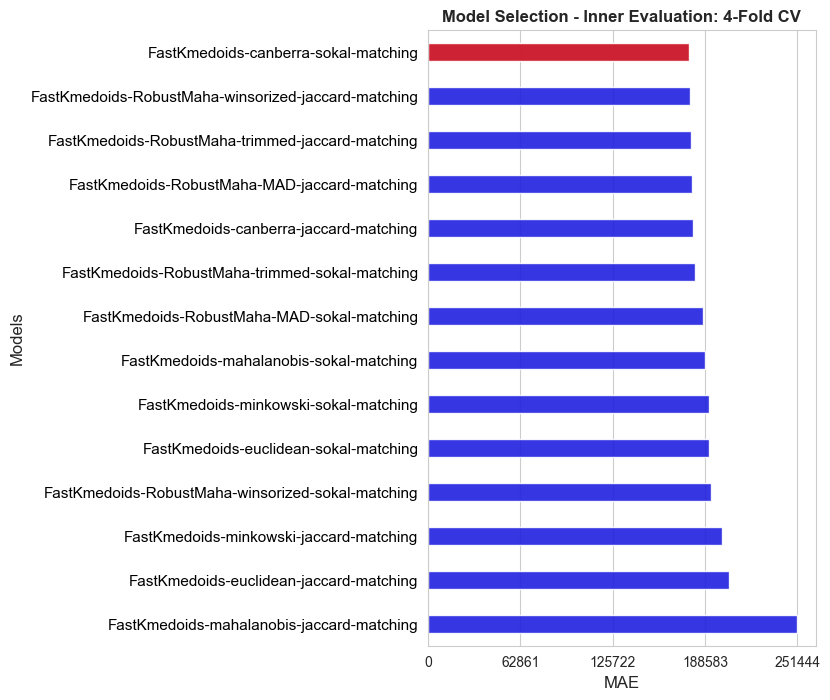

The best model among all the 14 alternatives plotted, according to the inner evaluation, is: FastKmedoids-canberra-sokal-matching
MAE of the best model: 177681.613

The best model hyper-parameters are: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__method': 'pam', 'clustering_model__init': 'heuristic', 'clustering_model__frac_sample_size': 0.03, 'clustering_model__d1': 'canberra', 'clustering_model__d2': 'sokal', 'clustering_model__estimators__0__n_estimators': 65, 'clustering_model__estimators__0__max_depth': 30.0, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 2, 'clustering_model__estimators__1__max_depth': 7.0, '

In [54]:
fig, axes = plt.subplots(figsize=(5,8))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('MAE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 5),3)) 
ax.tick_params(axis='y', labelsize=11)    
plt.title(f'Model Selection - Inner Evaluation: 4-Fold CV', size=12, weight='bold')
for label in ax.get_yticklabels():
    label.set_color('black') 
plt.show()

print(f'The best model among all the {len(sorted_scores)} alternatives plotted, according to the inner evaluation, is: {best_pipeline}')
print('MAE of the best model:', np.round(score_best_pipeline, 3))
print('\nThe best model hyper-parameters are:', best_params_large[best_pipeline])